# Project 4 - Part 2 Twitter Data

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import json
import pytz
import datetime



import re
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import os.path

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

In [3]:
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gorkemcamli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
%matplotlib inline

#### Read Data

In [5]:
repo_name = 'ECE219_tweet_data/'
file_names= ['tweets_#gohawks.txt',
             'tweets_#gopatriots.txt',
             'tweets_#nfl.txt',
             'tweets_#patriots.txt',
             'tweets_#sb49.txt',
             'tweets_#superbowl.txt'
]

df_names = []
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    df_names.append(file_name_key)

In [25]:
def read_txt_file(fname):
    "takes too long for the last sb49 and superbowl txt files"
    with open(fname) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']
    df_inter['json_element'].apply(json.loads)
    df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))    
    return df_final

def read_txt_file2(fname):
    "read line by line and get only what you need for Q27 and Q28"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['citation_date'].append(tweet['citation_date'])
            df_dict['retweet_count'].append(tweet['metrics']['citations']['total']) 
            df_dict['followers_count'].append(tweet['author']['followers'])

    df_final = pd.DataFrame(df_dict)
    return df_final

def read_txt_file3(fname):
    "read line by line and get only what you need for Q29"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['tweet.text'].append(tweet['tweet']['text'])
            df_dict['citation_date'].append(tweet['citation_date']) 
            df_dict['tweet.lang'].append(tweet['tweet']['lang'])
            df_dict['tweet.user.name'].append(tweet['tweet']['user']['name']) 
            df_dict['original_author.name'].append(tweet['original_author']['name']) 
            df_dict['tweet.favorite_count'].append(tweet['tweet']['favorite_count'])
            df_dict['tweet.retweet_count'].append(tweet['tweet']['retweet_count'])
            df_dict['metrics.citations.total'].append(tweet['metrics']['citations']['total']) 
            df_dict['metrics.impressions'].append(tweet['metrics']['impressions']) 
            df_dict['tweet.user.followers_count'].append(tweet['tweet']['user']['followers_count']) 
            df_dict['tweet.user.friends_count'].append(tweet['tweet']['user']['friends_count']) 
            df_dict['tweet.user.favourites_count'].append(tweet['tweet']['user']['favourites_count']) 

    df_final = pd.DataFrame(df_dict)
    return df_final
            

In [7]:
TIME_ZONE = 'US/Pacific'
PST_TZ = pytz.timezone(TIME_ZONE) # PST time zone 

## Question 27

__Report the following statistics for each hashtag, i.e. each file.__

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


In [8]:
tweet_dfs = {}
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    tweet_dfs[file_name_key] = read_txt_file2(fname=repo_name+file_name)
    print(file_name_key, tweet_dfs[file_name_key].shape)
    #display(tweet_dfs[file_name_key].head(3))

gohawks (169122, 4)
gopatriots (23511, 4)
nfl (233022, 4)
patriots (440621, 4)
sb49 (743649, 4)
superbowl (1213813, 4)


In [9]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    cur_df['citation_date_fixed'] = cur_df.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(x, PST_TZ)) 
    cur_df[new_cols] = cur_df.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    cur_df['citation_date_rounded_hour']= cur_df.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
  

KeyboardInterrupt: 

In [ ]:
def avg_tweet_per_hour(df):
    cols_group = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    return df.groupby(by=cols_group).title.count().mean()

def avg_num_followers(df):
    '''
    Average number of followers of users posting the tweets per tweet 
    (to make it simple, we average over the number of tweets; 
    if a users posted twice, we count the user and the user’s followers twice as well)
    '''
    avg_followers = df['followers_count'].mean()
    return avg_followers

def avg_retweet_per_tweet(df):
    return df['retweet_count'].mean()

In [ ]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    
    print(f'\n\n--- Stats for #{df_name} ---')
    avg_twt = avg_tweet_per_hour(cur_df)
    print('Average # tweet per hour', round(avg_twt,3))
    
    avg_flws = avg_num_followers(cur_df)
    print('Average # followers', round(avg_flws,3))
    
    avg_retweet_per_twt = avg_retweet_per_tweet(cur_df)
    print('Average # retweet per tweet', round(avg_retweet_per_twt,3))

## Question 28

__Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.__

In [ ]:
def plot_num_tweet_per_hour(df, df_name, x_ticks_freq=10):
    cols = ['citation_date_rounded_hour']
    gp_df = pd.DataFrame(df.groupby(by=cols).title.count())
    gp_df.sort_index(inplace=True)
    #gp_df.reset_index(inplace=True)
    gp_df.rename(columns={'title':'tweet_count_per_hour'}, inplace=True)
    
    ax = gp_df.plot(kind='bar',figsize=(30,7), rot=90)
    plt.title(f'{df_name} Bar Plot for Number of Tweets in hour over time')
    ax.set_ylabel('Tweet Count Per Hour')
    ax.set_xlabel('Citation Date')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text()[:-9] for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::x_ticks_freq])
    ax.xaxis.set_ticklabels(ticklabels[::x_ticks_freq])
    plt.show()
    
    


In [ ]:
for df_name in ['superbowl','nfl']:
    cur_df = tweet_dfs[df_name]
    plot_num_tweet_per_hour(cur_df, df_name, x_ticks_freq=20)

## Question 29

### Task Explanation

Follow the steps outlined below: 

- Describe your task.
- Explore the data and any metadata (you can even incorporate additional datasets if you choose).
- Describe the feature engineering process. Implement it with reason: Why are you extracting features this way - why not in any other way?
- Generate baselines for your final ML model.
- A thorough evaluation is necessary.
- Be creative in your task design - use things you have learned in other classes too if you are excited about them!

__Intro:__

In this design question I explored the twitter dataset from several different point of views: sentiment analysis, fan prediction and impression prediction.

The main objective is to understand which different ways we can consume the Twitter data.

__Task Description:__


__Subtasks:__

- Task 1: Character-centric time-series tracking: average perceived emotion across tweets about each player in the game across time in each fan base? Can we correlate these emotions with the team winning game?

- Task 2: With user and tweet meta data, can we predict the hashtag used?

- Task 3: TBD predict impressions

__Data Used:__

- '#gopatriots.csv' and '#gohawks.csv' files.
-  Additional data: 
    - Players information: I collected team player names, positions, position category information for Patriots and Seahawks team members who played at Superbowl 49.  
    - Game information: I used the score plays information to extract relative score times from tweets and label which team is the leading the game (patriots, sehawks, tie) when a tweet posted.


__Feature Engineering__

- emotion data
- label
- player data

__Prediction Models__
- Baselines
- Models


### __Data Preparation__

##### __Set GAME_START and GAME_END times__

In [26]:
# set naive datetime correctly
# (Add timezone to a naive datetime) from : https://medium.com/@eleroy/10-things-you-need-to-know-about-date-and-time-in-python-with-datetime-pytz-dateutil-timedelta-309bfbafb3f7

GAME_START = datetime.datetime(2015, 2, 1, 15, 30, 0, 0)
GAME_START = PST_TZ.localize(GAME_START)

GAME_END = datetime.datetime(2015, 2, 1, 19, 6, 0, 0)
GAME_END = PST_TZ.localize(GAME_END)
print('GAME_START',GAME_START)
print('GAME_END',GAME_END)

GAME_START 2015-02-01 15:30:00-08:00
GAME_END 2015-02-01 19:06:00-08:00


##### Helper functions

(to prepare data  extract features, feature engineering and prepare the dataset to be used in the tasks)

In [27]:
def read_q29_raw_data():
    tweet_dfs2 = {}
    for file_name in ['tweets_#gohawks.txt','tweets_#gopatriots.txt', 'tweets_#patriots.txt']:
        file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
        tweet_dfs2[file_name_key] = read_txt_file3(fname=repo_name+file_name)
        print(file_name_key, tweet_dfs2[file_name_key].shape)
        #display(tweet_dfs[file_name_key].head(3))

    tweet_dfs2['gohawks']['hashtag'] = '#gohawks'
    tweet_dfs2['gopatriots']['hashtag'] = '#gopatriots'
    tweet_dfs2['patriots']['hashtag'] = '#gopatriots'
    return tweet_dfs2

In [28]:
def clean_mentions_links(text):
    # clean mentions and links
    # mention count, link count, hashtag count
    
    mention_count = 0
    hashtag_count = 0
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        if t.startswith('@') and len(t) > 1:
            mention_count+=1
        if t.startswith('#') and len(t) > 1:
            hashtag_count+=1
            
        t = '' if t.startswith('@') and len(t) > 1 else t #'@user'
        t = '' if t.startswith('http') else t  #'http' 
        new_text.append(t)
    return [" ".join(new_text), mention_count, hashtag_count]

def clean_hashtag(text):
    # clean hashtag
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        t = '' if t.startswith('#') and len(t) > 1 else t #'@user'
        new_text.append(t)
    return " ".join(new_text)


def find_players_listed_in_tweet(tweet):
    players = []
    tweet_lower = tweet.lower()
    for player in list(players_df.Player.unique()):
        player_lower = player.lower()
        player_first, player_last = player_lower.split(' ')[0], player_lower.split(' ')[-1]
        
        if player_lower in tweet_lower or player_first in tweet_lower or player_last in tweet_lower:
            players.append(player)
    return None if not players else players

def game_interval(twt_time):
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < GAME_END:
        return 'during_game'
    else:
        return 'after_game'


In [29]:
def assign_nltk_sentiment_label(compound):
    # reference: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    label=None
    if compound >= 0.05:
        label='positive'
    elif (compound > -0.05) & (compound <0.05):
        label='neutral'
    else:
        label='negative'
    return label

def nltk_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_nltk_vader_'
    col_names = [prefix+'neg'+post_fix, prefix+'neu'+post_fix,prefix+'pos'+post_fix,prefix+'compound'+post_fix]
    
    if col_names[-1] in data.columns:
        return data
    else:
        sia = SentimentIntensityAnalyzer()
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(sia.polarity_scores(x)))
        data['sent_nltk_vader_label'+post_fix] =  data['sent_nltk_vader_compound'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data

def textblob_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_textblob_'
    col_names = [prefix+'polarity'+post_fix, prefix+'subjectivity'+post_fix]

    if col_names[0] in data.columns:
        return data
    else:
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(TextBlob(x).sentiment))
        data[prefix+'label'+post_fix] =  data[prefix+'polarity'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data


In [36]:
def date_time_fix(data):
    # prep posting time
    print('Starting posting time datetime features...')
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    data['citation_date_fixed'] = data.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(int(x), PST_TZ)) 
    data[new_cols] = data.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    data['citation_date_rounded_hour']= data.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
 
    return data

def prep_tweet_emotion_data(tweet_dfs2):
    fname = 'data/tweet_emt_df.csv'
    #print('Creating tweet_dfs2...')
    #tweet_dfs2 = read_q29_raw_data()
    if os.path.isfile(fname):
        tweet_emt_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        return tweet_emt_df
    else:  
        # create tweet_emt_df
        print('Starting tweet_emt_df...')
        cols = ['hashtag','title', 'tweet.text', 'citation_date','tweet.lang', 'tweet.user.name', 'original_author.name',
                'tweet.retweet_count','tweet.favorite_count','metrics.citations.total', 'metrics.impressions',
                'tweet.user.followers_count','tweet.user.friends_count','tweet.user.favourites_count',
               # 'author.followers','original_author.followers','original_author.influence_level', 'metrics.ranking_score', 
               # 'metrics.citations.influential',,'metrics.citations.replies',,'author.influence_level'
            ]
    
        # english tweets only
        tweet_dfs2['gohawks'] =  tweet_dfs2['gohawks'][tweet_dfs2['gohawks']['tweet.lang']=='en'] # english tweets only
        tweet_dfs2['gopatriots'] =  tweet_dfs2['gopatriots'][tweet_dfs2['gopatriots']['tweet.lang']=='en'] # english tweets only
        tweet_dfs2['patriots'] =  tweet_dfs2['patriots'][tweet_dfs2['patriots']['tweet.lang']=='en'] # english tweets only
        
        tweet_emt_df = pd.concat([tweet_dfs2['gohawks'][cols], tweet_dfs2['gopatriots'][cols], tweet_dfs2['patriots'][cols]])
        tweet_emt_df = tweet_emt_df.sort_values(by='citation_date')
        #tweet_emt_df = tweet_emt_df[tweet_emt_df['tweet.lang']=='en'] # english tweets only

        # prep posting time
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        
        # clean mentions and links
        #print('Starting cleaning title...')
        #tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

        # find players for each tweet 
        print('Starting find players...')
        tweet_emt_df['player'] = tweet_emt_df['tweet.text'].apply(lambda x: find_players_listed_in_tweet(tweet=x))
        tweet_emt_df['player_count'] = tweet_emt_df['player'].apply(lambda x: 0 if not x else len(x))
        tweet_emt_df['players_str'] = tweet_emt_df['player'].apply(lambda x: ', '.join(x) if x else '')
        tweet_emt_df['player2'] = tweet_emt_df['players_str'].astype(str).apply(lambda x:  'general' if x=='nan' or x=='' else x.split(',')[0])
        tweet_emt_df['player2'] = tweet_emt_df.apply(lambda x:  x['hashtag'] if x['player2']=='general' else x['player2'], axis=1)

        
        # create game status
        print('Starting game status...')
        tweet_emt_df['game_status'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval(twt_time=x))
        
        # nltk vader sentiment to title
        print('Starting nltk vader sentiment...')
        tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name='title')
        
        # textblob sentiment to title
        print('Starting textblob sentiment...')
        tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name='title')
                
        # write to not keep repeating same process
        tweet_emt_df.to_csv(fname)
        print(f'Saved file to {fname}...')
        tweet_emt_df.head(5)
        
        return tweet_emt_df
    

In [31]:
def create_players_data():
    fname = 'data/players_df.csv'
    if os.path.isfile(fname):
        players_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        return players_df
    else:
        players_df = pd.read_csv('data/sb 49 - players.csv')
        display(players_df.head(10).T)

        positions_df = pd.read_csv('data/sb 49 - positions.csv')
        display(positions_df.head(10).T)

        res = players_df.merge(positions_df, left_on='Pos', right_on='Abbreviation' , how='left')
        display(res.sample(10).T)

        res['player_first_name'] = res.Player.apply(lambda x: x.split(' ')[0])
        res['player_last_name']= res.Player.apply(lambda x: x.split(' ')[-1])
        res = res[res.espn_team_list==True]
        res.to_csv(fname)
        return res


#### __Prepare Twitter Data and Additional data__

To be able to create the tasks mentioned above, I need to first prepare the data, but some of the informations I need is not available within the Twitter dataset provided.

- Find Extra data:
    - Finding players data for each team
    - Finding game related scores, and significant events


##### __Players Data__

I used players and american football positions data found from below resources. I also crosschecked the team players info from espn website and added the missing players. Also, I realized that some players such as Dan Connolly didn't play in 2015 superbowl 49 (according to ESPN), so I created a new column espn_team_list to keep track of the players who played/not played in SB49.

References:
- players data: https://www.pro-football-reference.com/boxscores/201502010sea.htm#all_team_stats
- positions data: https://www.rookieroad.com/football/positions/position-abbreviations/

The final combined players table preview:

In [32]:
players_df = create_players_data()
print(players_df.shape)
display(players_df.head(5))

(39, 9)


,Player,Pos,Team,espn_team_list,Abbreviation,Position,Category,player_first_name,player_last_name
0,Tom Brady,QB,Patriots,True,QB,Quarterback,Offense,Tom,Brady
1,Shane Vereen,RB,Patriots,True,RB,Running Back,Offense,Shane,Vereen
2,Brandon LaFell,WR,Patriots,True,WR,Wide Receiver,Offense,Brandon,LaFell
3,Julian Edelman,WR,Patriots,True,WR,Wide Receiver,Offense,Julian,Edelman
4,Rob Gronkowski,TE,Patriots,True,TE,Tight End,Offense,Rob,Gronkowski


##### __Raw Tweet Data__

Read gohawks and go patriots data.

In [33]:
print('Creating tweet_dfs2...')
tweet_dfs2 = read_q29_raw_data()

Creating tweet_dfs2...
gohawks (169122, 13)
gopatriots (23511, 13)
patriots (440621, 13)


Language distribution of the tweets for each language:
(und:undecided)

In [34]:
print('gohawks\n')
display( pd.DataFrame(tweet_dfs2['gohawks']['tweet.lang'].value_counts(normalize=True)).head(10).T)
print('gopatriots\n')
display(pd.DataFrame(tweet_dfs2['gopatriots']['tweet.lang'].value_counts(normalize=True)).head(10).T)
print('patriots\n')
display(pd.DataFrame(tweet_dfs2['patriots']['tweet.lang'].value_counts(normalize=True)).head(10).T)


gohawks



,en,und,es,pt,de,fr,ja,tl,in,ht
tweet.lang,0.841801,0.119198,0.011104,0.008976,0.003737,0.001963,0.001904,0.001898,0.001721,0.000987


gopatriots



,en,und,es,pt,de,fr,ht,it,in,tl
tweet.lang,0.547999,0.18234,0.129131,0.089107,0.00906,0.008166,0.005614,0.004211,0.003785,0.003275


patriots



,en,und,es,pt,fr,de,ht,in,tl,it
tweet.lang,0.898008,0.048788,0.029399,0.005792,0.004142,0.002921,0.001441,0.001203,0.001067,0.00099


Given that we will do sentiment analysis task, I will only use english language tweets.


##### __Create Project Data__

We need to incorporate the newly collected data with the tweets data. This is not a trivial step as we need to know (1) if a tweet is about a specific player, (2) mapping game time to real time.
(1) is handled in this section and (2) has its own specific part since it is more complex.    

In this step I prepared the final raw data to be used in the above described tasks:

Steps followed to prepare this data:
- Select features from raw tweet data
- Filter to have english language only
- Concat gohawks and gopatriots data in a single dataframe, put hashtag column to later use to separate them.
- Handle date time information for citation_date column.
- Game Status: create a column to specify when the tweet is posted: 'pre-game, during game' and 'after game'
- Map tweets and players
- Sentiment Analysis 
	- nltk vader
	- teextblob


Further details for some of the above steps:

__Selected features from raw tweets data:__

['title', 'tweet.text', 'citation_date','hashtag', 'tweet.lang', 'tweet.user.name', 'original_author.name',
'tweet.entities.hashtags','tweet.entities.user_mentions','tweet.retweet_count','tweet.favorite_count',
'tweet.user.followers_count','tweet.user.friends_count','tweet.user.favourites_count','author.followers',
'original_author.followers','original_author.influence_level', 'metrics.ranking_score', 'metrics.citations.influential',
'metrics.citations.total','metrics.citations.matching','metrics.citations.replies','metrics.impressions','author.influence_level']

 todo change later features

__Date time:__

Twitter raw data has citation_date column as the tweet post time. This column values are in the form of UNIX time as a scalar number. I first convert this column to a human-readable format using datetime and converted the timezone to PST time zone. I also used PST time zone for significant times in the game such as game start and end time to be able to easily filter out tweets during game time. I also created additional year, month, day, hour columns for convenience.


__Find if a tweet about a specific player:__

In order to make a character-centric tracking we need to know whether a tweet is related to a player. There are several ways we can see a tweet could be related to a player: if tweet text mentions the player, uses hashtag about player and use the name of the player. 

I used a simple logic with full name and partial name to match to find tweets about players. The results are case insensitive. By doing this I can identify players for 20% of the tweet data with 1 or more than 1 players. 
This could be further improved by finding twitter usernames of the players (for mentions) and specific hashtags used for players. However, most of these already contains either full, first or last name of the players meaning most of these case would be handled already with the current logic. Several columns created: player (list of the players found), player_count (number of players identified in a tweet), player2 (same as player but with team names for tweets no player found).

What will happen to the remaining 80% of the tweets? Well, since I didn't want to discard them directly I assigned team names to the tweets that we couldn't find specific players. We can filter them out later or can use it to enhance our model results. 

__Sentiment Analysis:__

For sentiment analysis, we need sentiment information. Two libraries used to extract sentiment information: nltk and textblob. With nltk.vader, I found positive, negative, neutral and compound scores for each tweet. Assigned the labels using compound score. With TextBlob, I extracted polarity and sensitivity information and assigned the label using polarity information.

For the character centric analysis, we need to aggregate these emotion values, for each character and time interval. I decribed those steps in the later sections for the specific task (Task 1).

I experimented extracting sentiment information with both cleaned and uncleaned tweets, the change in the results were insignificant. I shared them later in the notebook.


Also, applying these steps take considerable time, in order to not rerun the same things over and over, I saved the final df and reread when I restart working. 

__Preview of the project data:__

In [37]:
tweet_emt_df = prep_tweet_emotion_data(tweet_dfs2=tweet_dfs2)
print(tweet_emt_df.shape)
tweet_emt_df.head(3)

Starting tweet_emt_df...
Starting posting time datetime features...
Starting find players...
Starting game status...
Starting nltk vader sentiment...
Starting textblob sentiment...
Saved file to data/tweet_emt_df.csv...
(550932, 33)


,hashtag,title,tweet.text,citation_date,tweet.lang,tweet.user.name,original_author.name,tweet.retweet_count,tweet.favorite_count,metrics.citations.total,...,player2,game_status,sent_nltk_vader_neg_title,sent_nltk_vader_neu_title,sent_nltk_vader_pos_title,sent_nltk_vader_compound_title,sent_nltk_vader_label_title,sent_textblob_polarity_title,sent_textblob_subjectivity_title,sent_textblob_label_title
205,#gohawks,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,1421222681,en,Nathan Santo Domingo,Nathan Santo Domingo,0,0,1,...,#gohawks,pre_game,0.0,1.000,0.000,0.0000,neutral,0.0,0.000,neutral
203,#gohawks,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,1421222750,en,Dr Gerry Ramogida,Dr Gerry Ramogida,0,0,3,...,#gohawks,pre_game,0.0,0.618,0.382,0.8718,positive,0.5,0.625,positive
143,#gopatriots,NFL PLAYOFFS: Brady throws 3 TDs in win over R...,NFL PLAYOFFS: Brady throws 3 TDs in win over R...,1421222838,en,TeH pHiLaDeLpHIa iNq,TeH pHiLaDeLpHIa iNq,0,0,1,...,Tom Brady,pre_game,0.0,0.743,0.257,0.5859,positive,0.8,0.400,positive


### __Data Exploration & Feature Engineering__

##### __Answer some questions__

- __Check if data is balanced for each team?__

In [38]:
print(tweet_emt_df.hashtag.value_counts())
tweet_emt_df.hashtag.value_counts(normalize=True)

#gopatriots    408565
#gohawks       142367
Name: hashtag, dtype: int64


#gopatriots    0.741589
#gohawks       0.258411
Name: hashtag, dtype: float64

We have highly inbalanced data, gohawks tweets corresponds to the almost 92% of the data. 

- __Find in how many tweets each player is mentioned?__

In [39]:
dd = pd.DataFrame(tweet_emt_df.groupby(by=['player2']).title.count())
dd = dd.sort_values(by='title', ascending=False)
dd.head(50)

,title
player2,
#gopatriots,357785
#gohawks,115377
Tom Brady,32383
Russell Wilson,8710
Rob Gronkowski,5395
Marshawn Lynch,4845
Richard Sherman,4314
Chris Matthews,2753
Julian Edelman,2439


- __What is the ratio of number of players found on tweet dataset?__

Show player_count column's normalized  value counts.

In [40]:
tweet_emt_df.player_count.value_counts(normalize=True)

0     0.858839
1     0.116221
2     0.018329
3     0.005231
4     0.001049
5     0.000231
6     0.000069
7     0.000015
8     0.000011
9     0.000004
10    0.000002
Name: player_count, dtype: float64

##### __Cleaning Tweets:__



I did a minimum cleaning on the tweets to experiment on whether text cleaning will further change the emotions distributions for tweets, and help with the model performances.

Cleaned title column: cleans the links and mentions from the tweet.
Cleaned hashtag title column: in addition to links and mentions, also cleans the hashtags from the tweet.


In [41]:
# clean title
tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

In [42]:
tweet_emt_df['cleaned_hashtag_title'] = tweet_emt_df.cleaned_title.apply(lambda x: clean_hashtag(x))

#### __Creating Sentiment Scoring and Label Features__

##### __nltk.sentiment.vader__

As my first baseline sentiment analysis score approach, I used nltk.sentiment.vader.

VADER stands for Valence Aware Dictionary for Sentiment Reasoning. Vader is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion and one can apply Vader model directly to unlabeled text to get scores for negative, neutral and positive sentiments. Nltk.sentiment.vader also provides a compound score: "is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

To assign positive, neutral and negative labels, I used the compound score and recommended thresholds in the nltk documentaion: https://github.com/cjhutto/vaderSentiment#about-the-scoring

- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

I applied Vader model to raw tweets data, cleaned_title and cleaned_hashtag_title columns. 
When we grouped and check what the ratios for each label, I don't see any huge shift in the overall distribution in emotion for the raw vs cleaned tweets.

In [43]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_nltk_vader_label_'+twt_feature_name].value_counts(normalize=True))

title


positive    0.610240
neutral     0.280111
negative    0.109649
Name: sent_nltk_vader_label_title, dtype: float64

cleaned_title


positive    0.610313
neutral     0.280203
negative    0.109484
Name: sent_nltk_vader_label_cleaned_title, dtype: float64

cleaned_hashtag_title


positive    0.609850
neutral     0.280681
negative    0.109469
Name: sent_nltk_vader_label_cleaned_hashtag_title, dtype: float64

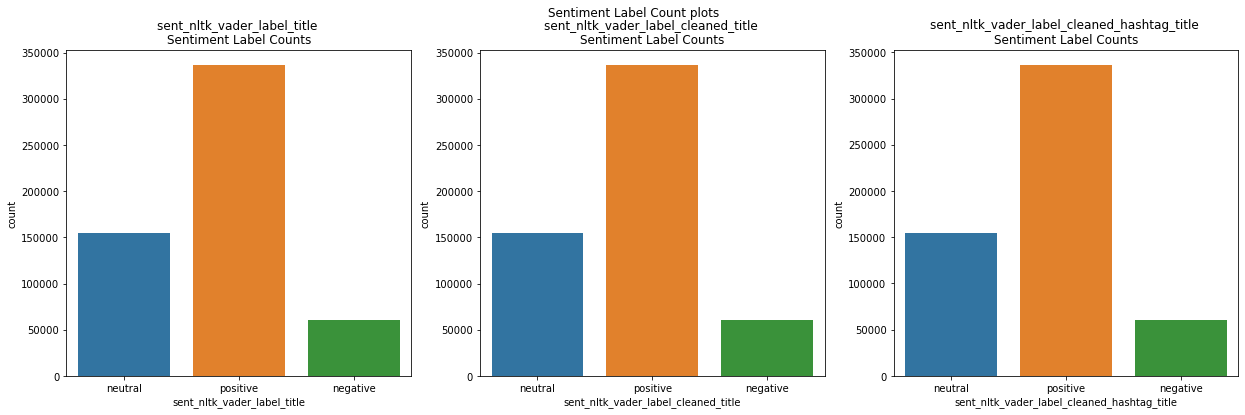

In [44]:
for ft, s in zip(['sent_nltk_vader_label_'], ['Label']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Count plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.countplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
    plt.show()

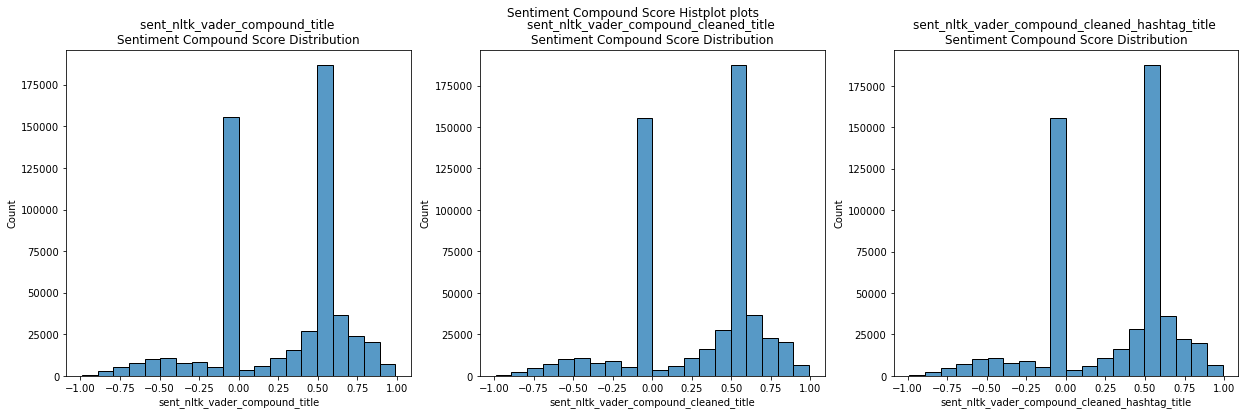

In [45]:
for ft, s in zip(['sent_nltk_vader_compound_'], ['Compound Score']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Histplot plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.histplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind, bins=20)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
    plt.show()

We can see that majority of the labels assigneed positive tag, however their compound score is relatively closer to the neural side. 

##### __TextBlob sentiment__

In [46]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_textblob_label_'+twt_feature_name].value_counts(normalize=True))

title


positive    0.569557
neutral     0.320936
negative    0.109507
Name: sent_textblob_label_title, dtype: float64

cleaned_title


positive    0.569103
neutral     0.321288
negative    0.109609
Name: sent_textblob_label_cleaned_title, dtype: float64

cleaned_hashtag_title


positive    0.564556
neutral     0.326089
negative    0.109355
Name: sent_textblob_label_cleaned_hashtag_title, dtype: float64

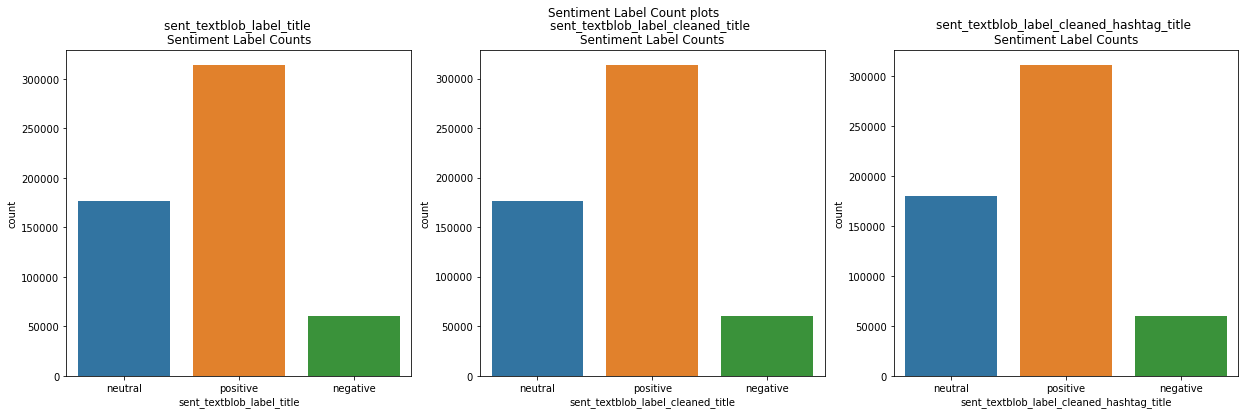

In [47]:
for ft, s in zip(['sent_textblob_label_'], ['Label']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Count plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.countplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Counts')
    plt.show()

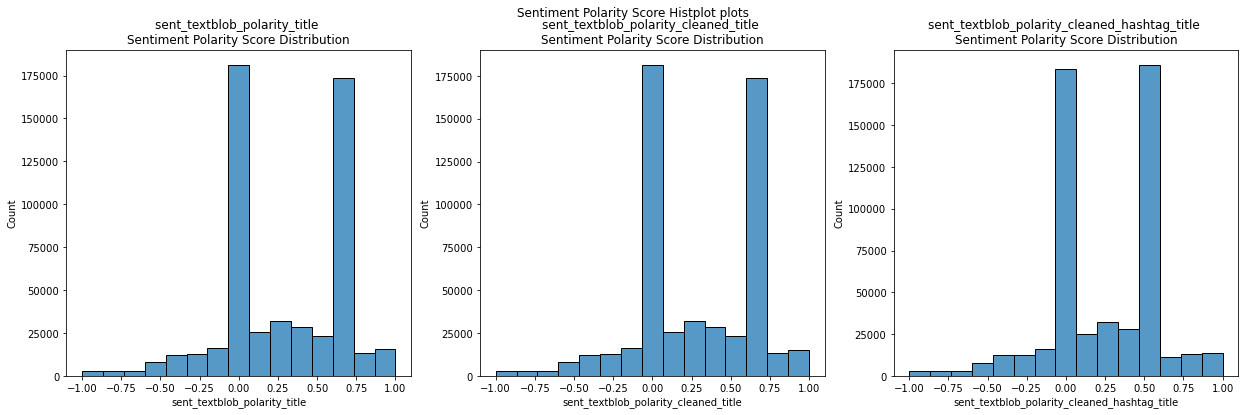

In [48]:
for ft, s in zip(['sent_textblob_polarity_'], ['Polarity Score']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,6))
    plt.suptitle(f'Sentiment {s} Histplot plots')
    for twt_feature_name, ax_ind in zip(['title', 'cleaned_title','cleaned_hashtag_title'], ax.ravel()):
        sns.histplot(tweet_emt_df[ft+twt_feature_name], ax=ax_ind, bins=15)
        ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
    plt.show()

We can see that majority of the labels assigned neutral tag. Cleaned data doesn't shift distributions at least on the eye level. 

In [49]:
tweet_emt_df.to_csv('data/tweet_emt_df.csv')

##### __Roberta sentiment__ (to do either use or delete later)

In [50]:
'''
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from tqdm import tqdm

tqdm.pandas()
'''

'\nfrom transformers import AutoModelForSequenceClassification\nfrom transformers import AutoTokenizer\nimport numpy as np\nfrom scipy.special import softmax\nimport csv\nimport urllib.request\nfrom tqdm import tqdm\n\ntqdm.pandas()\n'

In [51]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
def get_roberta_model():
    task='sentiment'
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    # PT
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.save_pretrained(MODEL)
    return model, labels

def sample_usage(model):
    # sample roberta usage
    text = "Good night 😊"
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")
        
def apply_roberta(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return pd.Series(scores)

In [52]:
#prefix ='sent_roberta_'
#col_names = [prefix+'neg', prefix+'neut', prefix+'pos']
#model, labels = get_roberta_model()
#sample_usage(model)

#tweet_emt_df[col_names] = tweet_emt_df['title'].apply(lambda x: apply_roberta(text=x))
#tweet_emt_df[col_names] = tweet_emt_df['title'].progress_apply(lambda x: apply_roberta(text=x))
#tweet_emt_df[prefix+'label'] =  tweet_emt_df[prefix+'pos'] #.apply(lambda x: assign_nltk_sentiment_label(x))

#### __Mapping Game Time to Real Time:__

There are 3 main time information we need to find
1. Categorize tweets as pre, during and after game.
2. Find quarter and halftime show beginning and end times. 
3. Find score times.
4. Find significant event times (interceptions, fumbles).

One of the biggest challenge I had is to map the real time with the game time. Game scores and significant events data available on the internet is relative to the game time such as first touch down is happend in second quarter 9:47 (example: https://www.espn.com/nfl/playbyplay/_/gameId/400749027 check all plays and scoring plays table). However, tweets are based on real time. 

Unfortunately, game clock isn't kept counting down continuously during game. Even though game is considered 1 hour with each quarter 15 minutes, I realized that the actual game took generally 2-3 hours. In the superbowl 49 case, it took 3h 36 minutes as written on the internet. Hence, I need to find a way to map the game time and real time where tweets are written.

I tried several things on how to assign time frames. My first approach was to find timestamps of the game (either significant event or scores), but after hours of search it lead me nowhere:

- I couldn't find any data online that is relative to real timestamps like PST, UTC on neither on quarter start and end, nor for significant or score times. Every play by play and score play data I found were on relative to the game time shown minutes within quarters. 

- Checked youtube videos of the full game, to extract times manually, either by checking time on the screen or find it relative from video time. In full game video, there is no real time shown on the screen and I realized that the video was shortened where halftime shows removed, so that didn't helped either on mapping the game time to real time.

- I tried to find timestamps from the tweets of official twitter accounts of Seattle Seahawks and Patriots. I check both dataset and then twitter but the tweets from there limited and you can't infer any of the information completely.
- Final resort: refer score and quarter times from tweet dataset. Assumption: if a tweet with score is tweeted than either one of the team is already scored, use the earliest one within the game timeframe.

- As a last resort, I decided to extract the score times and quarter times from the tweets. 

PS: I skipped the (4) Find significant event times (interceptions, fumbles), since there is no fumbles in the game and finding interceptions from tweets both very difficult and not very reliable.

##### __1. Categorize tweets as pre, during and after game:__

We already know the game start time 3:30 PST and how long game lasted 3 hours 36 min. By using start and game end time we  can assign pre-game, during game and after game tags to each tweet. The distribution of game status can be seen below:

In [53]:
tweet_emt_df.game_status.value_counts()

pre_game       408154
during_game     89804
after_game      52974
Name: game_status, dtype: int64

In [54]:
tweet_emt_df.game_status.value_counts(normalize=True)

pre_game       0.740843
during_game    0.163004
after_game     0.096153
Name: game_status, dtype: float64

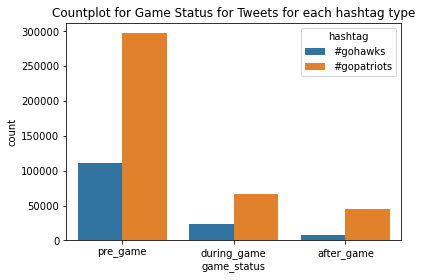

In [55]:
game_status_categories = ['pre_game', 'during_game','after_game']
plt.Figure(figsize=(10,10))
sns.countplot(data=tweet_emt_df, x='game_status', hue='hashtag', order=game_status_categories)
plt.title('Countplot for Game Status for Tweets for each hashtag type')
plt.show()

Most of the tweets were posted before game, so American Football fans, especially Patriots and SeaHawks are really fans and they watch the game during game, instead of posting tweet about it.

Distribution of tweets by each fan and game status:

In [56]:
tweet_emt_df.groupby(by=['hashtag', 'game_status']).title.count()

hashtag      game_status
#gohawks     after_game       7761
             during_game     23706
             pre_game       110900
#gopatriots  after_game      45213
             during_game     66098
             pre_game       297254
Name: title, dtype: int64

##### __2.1. Finding Quarter Times:__

To go one step further, I used the tweet information to find approximate quarter times. 

For each quarter, I checked the tweets that has 'end of' and quarter name in the same tweet. 
For example for first quarter, I filtered out only tweets that has 'end of' and either '1st quarter' or 'first quarter' substrings.

The results are not too many, so I manually checked the meanings and assigned the earliest tweet that refers to the end of quarter. In this case, the results are driven from users and approximate, but the best mapping I could find.

In [57]:
# find the relative time frames for each quarter
quarter_strs = ['first quarter|1st quarter','second quarter|2nd quarter', 'third quarter|3rd quarter', 'fourth quarter|4th quarter']
cs = ['title','citation_date_fixed']

for qs in quarter_strs:
    print(f'Looking matches for {qs} ...')
    display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('end of')) &
                (tweet_emt_df['tweet.text'].str.contains(qs)) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)][cs])

Looking matches for first quarter|1st quarter ...


,title,citation_date_fixed
326743,0-0 at the end of the first quarter. #Seahawks...,2015-02-01 15:58:08-08:00
326751,#SB49 end of first quarter. #Seattle 0 #Patrio...,2015-02-01 15:58:09-08:00
326852,At the end of the first quarter the game is ti...,2015-02-01 15:58:26-08:00
326869,It's scoreless between the #Patriots & #Seahaw...,2015-02-01 15:58:29-08:00
326871,"At the end of the 1st quarter, score is 0-0! #...",2015-02-01 15:58:29-08:00
327117,"At the end of a speedy first quarter, #SuperBo...",2015-02-01 15:59:02-08:00
327118,"At the end of a speedy first quarter, #SuperBo...",2015-02-01 15:59:02-08:00
327134,And thatâs the end of the 1st quarter. 0-0. ...,2015-02-01 15:59:05-08:00
327161,"Alright, whoever had 0-0 at the end of the 1st...",2015-02-01 15:59:08-08:00
135879,At the end off the first quarter yhe score is ...,2015-02-01 15:59:25-08:00


Looking matches for second quarter|2nd quarter ...


,title,citation_date_fixed
344990,agreement btwn #Seahawks &amp; #Patriots: make...,2015-02-01 16:35:29-08:00
146119,@DJAelita @TheFaithBreaker 14 - 14 at the end ...,2015-02-01 17:09:09-08:00
363592,I swear the #SB49 is paid to win.. We were pla...,2015-02-01 17:46:58-08:00
368063,#patriots have to show the same guts the #Seat...,2015-02-01 18:11:09-08:00
167393,Last play last nite was a bad call cuz it didn...,2015-02-02 07:33:55-08:00


Looking matches for third quarter|3rd quarter ...


,title,citation_date_fixed
368081,"The #Seahawks lead the #Patriots, 24-14, at th...",2015-02-01 18:11:15-08:00
369140,"At the end of the 3rd quarter, the #Seahawks h...",2015-02-01 18:18:36-08:00
155209,24-14 at the end of 3rd quarter. Seahawks lead...,2015-02-01 18:18:37-08:00


Looking matches for fourth quarter|4th quarter ...


,title,citation_date_fixed
367976,At the end of the 4th quarter of #SuperBowlXLI...,2015-02-01 18:10:43-08:00
374146,You HAVE to have a big lead on the #Patriots a...,2015-02-01 18:39:49-08:00
157606,Made it just for the end of the fourth quarter...,2015-02-01 18:48:30-08:00
158797,Coming from behind in end of 4th quarter is wh...,2015-02-01 18:53:28-08:00
423158,Seahawks last great play near the end of the 4...,2015-02-02 00:15:37-08:00
167012,"So... Yes, stupid call at the end of the game....",2015-02-02 05:23:54-08:00


__2.2. Finding Halftime Show Times:__

I used a similar approach above and used halftime and various strings for Katty Perry who performed at the half time: 'Katty Perry|@kattyperry|katty'

In [58]:
# estimate halftime show start and end times
expected_halftime_show_time = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
expected_halftime_show_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

res = tweet_emt_df[((tweet_emt_df['tweet.text'].str.contains('halftime')) |
                (tweet_emt_df['tweet.text'].str.contains('Katty Perry|@kattyperry|katty'))) &
                (expected_halftime_show_time_end > tweet_emt_df['citation_date_fixed']) &
                 ( tweet_emt_df['citation_date_fixed'] > expected_halftime_show_time)][['title','citation_date_fixed']]

print('Check Head 10 of the found tweeets:')
display(res.head(10))
print('Check Tail 10 of the found tweeets:')
display(res.tail(10))

Check Head 10 of the found tweeets:


,title,citation_date_fixed
357441,Game tied at the half! Who will win? #SuperBow...,2015-02-01 17:05:02-08:00
15738,Well it's halftime and the game is tied at 14 ...,2015-02-01 17:05:09-08:00
145530,so i catch the game shortly before halftime. ...,2015-02-01 17:05:10-08:00
357509,"Shit it's halftime, what channel is the blowjo...",2015-02-01 17:05:16-08:00
357512,Super Bowl 49 #patriots #brady #halftime #icec...,2015-02-01 17:05:17-08:00
357513,#katyperry #halftime \n#patriots — watching Su...,2015-02-01 17:05:17-08:00
357553,"Wow exciting superbowl 2 great teams 2 big QB,...",2015-02-01 17:05:26-08:00
145584,That's how you go to halftime. 💙💚 #GoHawks,2015-02-01 17:05:28-08:00
357565,What a game halftime great #SuperBowlXLIX #Pat...,2015-02-01 17:05:30-08:00
357568,Super Bowl halftime shows are a turd oasis wit...,2015-02-01 17:05:31-08:00


Check Tail 10 of the found tweeets:


,title,citation_date_fixed
16051,Bad ass halftime show! @katyperry @pepsi #SBXL...,2015-02-01 17:18:39-08:00
359792,"@katyperry is just incredible, I'm in love #ha...",2015-02-01 17:18:40-08:00
146765,So far my favorite halftime show ever. #katype...,2015-02-01 17:18:40-08:00
146773,Loving the halftime #GoHawks,2015-02-01 17:18:50-08:00
146777,I'm quite enjoying KP halftime show\n\n#GoHawks,2015-02-01 17:18:55-08:00
146781,This halftime show is so damn good! Katy Perry...,2015-02-01 17:18:59-08:00
16057,You're gonna hear me ROAR katyperry #katyperry...,2015-02-01 17:19:20-08:00
146800,I'm so glad Katy Perry is doing halftime... Be...,2015-02-01 17:19:35-08:00
146809,@katyperry @LennyKravitz Awesome halftime show...,2015-02-01 17:19:46-08:00
359908,Missy made a comeback! #superbowl #halftime #p...,2015-02-01 17:19:55-08:00


I also explored other combinations for 'halftime' and 'started|start' and 'halftime and end|ended' tweet matches to further investigate. Also, from Google and youtube videos, I found that the halftime show lasted 12 minutes 35 seconds. I incorporated this information with some buffer time as well.

Again the times are rather approximate, but this will at least help us in approximately when in the game, these tweets are being posted and put the information conceptually in place. Final time intervals I decided are below:

In [59]:
def create_time(tm):
    return PST_TZ.localize(tm)
     
quarter_times = {
    'first_qt_start' : GAME_START,
    'first_qt_end' : create_time(datetime.datetime(2015, 2, 1, 16, 0, 0, 0)),
    'second_qt_start' : create_time(datetime.datetime(2015, 2, 1, 16, 0, 0, 0)), #first_qt_end,
    'second_qt_end' : create_time(datetime.datetime(2015, 2, 1, 17, 9, 0, 0)),

    'half_time_start' : create_time(datetime.datetime(2015, 2, 1, 17, 9, 0, 0)),
    'half_time_end' : create_time(datetime.datetime(2015, 2, 1, 17, 27, 0, 0)),

    'third_qt_start' : create_time(datetime.datetime(2015, 2, 1, 17, 27, 0, 0)), #half_time_end,
    'third_qt_end' : create_time(datetime.datetime(2015, 2, 1, 18, 18, 0, 0)),

    'fourth_qt_start': create_time(datetime.datetime(2015, 2, 1, 18, 18, 0, 0)), #third_qt_end,
    'fourth_qt_end' : GAME_END
}
print('\n'.join([ f'{k} : {v}'    for k, v in quarter_times.items()]))

first_qt_start : 2015-02-01 15:30:00-08:00
first_qt_end : 2015-02-01 16:00:00-08:00
second_qt_start : 2015-02-01 16:00:00-08:00
second_qt_end : 2015-02-01 17:09:00-08:00
half_time_start : 2015-02-01 17:09:00-08:00
half_time_end : 2015-02-01 17:27:00-08:00
third_qt_start : 2015-02-01 17:27:00-08:00
third_qt_end : 2015-02-01 18:18:00-08:00
fourth_qt_start : 2015-02-01 18:18:00-08:00
fourth_qt_end : 2015-02-01 19:06:00-08:00


In [60]:
def game_interval2(twt_time):
    
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START <= twt_time < quarter_times['first_qt_end']:
        return 'first-quarter'
    elif quarter_times['second_qt_start'] <= twt_time < quarter_times['second_qt_end']:
        return 'second-quarter'
    elif quarter_times['half_time_start'] <= twt_time < quarter_times['half_time_end']:
        return 'half-time show'
    elif quarter_times['third_qt_start'] <= twt_time < quarter_times['third_qt_end']:
        return 'third-quarter'
    elif quarter_times['fourth_qt_start'] <= twt_time < GAME_END:
        return 'fourth-quarter'
    else:
        return 'after_game'
    
tweet_emt_df['game_status_detailed'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval2(twt_time=x) )

Distribution of tweets by each fan and game detailed status:

In [61]:
tweet_emt_df.groupby(by=['hashtag', 'game_status_detailed']).title.count()

hashtag      game_status_detailed
#gohawks     after_game                7755
             first-quarter             3909
             fourth-quarter            4642
             half-time show             900
             pre_game                110900
             second-quarter            8025
             third-quarter             6236
#gopatriots  after_game               45203
             first-quarter            13853
             fourth-quarter           15808
             half-time show            1921
             pre_game                297254
             second-quarter           27224
             third-quarter             7302
Name: title, dtype: int64

The final time mapping missing is to identifying the times where scores changed. I address this part on feature engineering section.

##### __3. Finding Score Times:__

I know the scores of the game, so with regex I searched the tweets where scores shared, and from those tweets I filtered and kept only the correct scores realized within the duration of the game (see scores_list). 

scores_list = ['7-0','7-7','14-7','14-14','14-17','14-24','21-24','28-24']

This is especially important because there are some tweets with prediction scores of the game. Also, according to american footbal rules, once touchdown happens a team gets 6 points and then with extras that score can increase up to 1 or 2 more points. Some tweets were posted without the extra points (ie 14-23) so scores_list helped me filter out those as well since I want to be consistent with the Scoring Plays results I dounf in espn website (https://www.espn.com/nfl/playbyplay/_/gameId/400749027). I also limited the post date of the tweets after game start time to make sure to get real scores. 

Then, my assumption is that if a user tweets the score, then it means there is a change in score and one of the team has scored. And I could use the relative real time of the score by taking the time of the earliest tweet posted with that score. In this way for each score, I can have a relative real tweet times in PST time where each score happened. Of course, the earliest tweet might be posted couple minutes later and might not be exact with the score time. But this is the best approximation and map I could get with the available data I have.

As a sanity check I also looked whether the found time frames fall in the relative place in the quarter the score happened. You can see the final dataframe with score and time mapping below:

In [62]:
scores_list = ['7-0','7-7', '14-7','14-14','14-17','14-24','21-24','28-24']

# regex to find scores of the game written by users in the tweets
strs = r'(0|[1-9]\d*)-(0|[1-9]\d*)' #'(0|[1-9]\d*)-(0|[1-9]\d*)|(0|[1-9]\d*) - (0|[1-9]\d*)' #'touchdown|td|Touch down|Touchdown|TD'
sub_twt_df = tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains(strs)) &
                          (tweet_emt_df['citation_date_fixed'] > GAME_START)] 

res = sub_twt_df['tweet.text'].str.extract(strs, expand=True)
res['score'] = res.apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)
res = res[res.score.isin(scores_list)]

sub_twt_df = pd.concat([sub_twt_df,res], axis=1)

cls = ['citation_date_fixed', 'score']
score_not_null = sub_twt_df[sub_twt_df.score.notnull()]
#display(score_not_null[cls])

score_time_df = score_not_null[cls].groupby(by=['score']).first()
score_time_df = score_time_df.reindex(scores_list)
score_time_df.reset_index(inplace=True)
def find_leading(score):
    scores = score.split('-')
    pat_score = int(scores[0])
    hawk_score = int(scores[1])
    leading=''
    if pat_score==hawk_score:
        leading='Tie' 
    elif pat_score > hawk_score:
        leading='Patriots'
    else:
        leading='Seahawks'
    return leading
score_time_df['leading']= score_time_df.score.apply(lambda x: find_leading(x))
start = pd.DataFrame([['0-0', GAME_START, 'Tie' ]], columns=['score', 'citation_date_fixed', 'leading'])
score_time_df = pd.concat([start, score_time_df])

def find_quarter(x_dt):
    dic_k = {'first_qt_start':'1st Quarter', 'second_qt_end':'2nd Quarter',
             'third_qt_end':'3rd Quarter','fourth_qt_end':'4th Quarter'}
    for k,v in quarter_times.items():
        if x_dt <= v:
            return dic_k[k]
score_time_df['quarter'] =score_time_df.citation_date_fixed.apply(lambda x:find_quarter(x))
display(score_time_df)

,score,citation_date_fixed,leading,quarter
0,0-0,2015-02-01 15:30:00-08:00,Tie,1st Quarter
0,7-0,2015-02-01 16:12:34-08:00,Patriots,2nd Quarter
1,7-7,2015-02-01 16:33:56-08:00,Tie,2nd Quarter
2,14-7,2015-02-01 16:48:33-08:00,Patriots,2nd Quarter
3,14-14,2015-02-01 16:59:57-08:00,Tie,2nd Quarter
4,14-17,2015-02-01 17:37:23-08:00,Seahawks,3rd Quarter
5,14-24,2015-02-01 18:15:38-08:00,Seahawks,3rd Quarter
6,21-24,2015-02-01 18:29:34-08:00,Seahawks,4th Quarter
7,28-24,2015-02-01 18:48:19-08:00,Patriots,4th Quarter


In [93]:
sub_twt_df.citation_date_fixed

11781    2015-02-01 15:49:45-08:00
11907    2015-02-01 15:52:59-08:00
12115    2015-02-01 15:58:27-08:00
12221    2015-02-01 16:02:43-08:00
12287    2015-02-01 16:04:52-08:00
                    ...           
438877   2015-02-05 11:38:33-08:00
439443   2015-02-06 03:00:49-08:00
439624   2015-02-06 08:04:00-08:00
439648   2015-02-06 08:27:14-08:00
439795   2015-02-06 10:16:40-08:00
Name: citation_date_fixed, Length: 3159, dtype: datetime64[ns, US/Pacific]

This table shows approximately at what time the score happened according to the tweets, in which quarter and who is leading the game after the score. I will use this data frame to table my data for the prediction task.

to do maybe insert scoring plays screenshot here: https://www.espn.com/nfl/playbyplay/_/gameId/400749027

## Character-centric time-series tracking

__Can we track the average perceived emotion across tweets about each player in the game across time in each fan base?__

todo give intro..


In [63]:
twt_feature_name = 'cleaned_title'
sentiment_feature = 'sent_nltk_vader_compound'+'_'+twt_feature_name   #sent_nltk_vader_compound, 'sent_textblob_polarity'
round_num = 1
time_interval_feature = f'post_time_{round_num}_intervals' #post_time_2_intervals

In [64]:
def timeround(tm, round_val=10):
    tm += datetime.timedelta(minutes=int(round_val/2))
    tm -= datetime.timedelta(minutes=tm.minute % round_val,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    return tm

tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))
tweet_emt_df[['citation_date_fixed', time_interval_feature]].head(5)

,citation_date_fixed,post_time_1_intervals
205,2015-01-14 00:04:41-08:00,2015-01-14 00:04:00-08:00
203,2015-01-14 00:05:50-08:00,2015-01-14 00:05:00-08:00
143,2015-01-14 00:07:18-08:00,2015-01-14 00:07:00-08:00
144,2015-01-14 00:09:58-08:00,2015-01-14 00:09:00-08:00
208,2015-01-14 00:12:20-08:00,2015-01-14 00:12:00-08:00


In [65]:
def plot_fancy(ax_ind=None, set_ylim=True):
    txts = ['1st Quarter', '2nd Quarter', 'Halftime Show', '3rd Quarter', '4th Quarter']
    times_texts = [create_time(datetime.datetime(2015, 2, 1, 15, 40, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 16, 30, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 17, 10, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 17, 40, 0, 0)),
                  create_time(datetime.datetime(2015, 2, 1, 18, 30, 0, 0))
             ]
    times_scores = [create_time(datetime.datetime(2015, 2, 1, 15, 30, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 12, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 33, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 48, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 16, 59, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 17, 37, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 15, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 29, 0, 0)),
                    create_time(datetime.datetime(2015, 2, 1, 18, 48, 0, 0))
             ]
    for tm, txt, time in zip(['first_qt_end', 'second_qt_end', 'half_time_start','half_time_end', 'third_qt_end', 'fourth_qt_end'], txts, times_texts):
        if ax_ind:
            ax_ind.axvline(quarter_times[tm], color='lightgrey', linestyle='--')    # Plot a vertical line at corresponding x
            ax_ind.text(time, 1.03, txt, fontsize = 10,  color='gray') 
        else:        
            plt.axvline(quarter_times[tm], color='lightgrey', linestyle='--') # Plot a vertical line at corresponding x
            plt.text(time, 1.03, txt, fontsize = 10,  color='gray')
        

    for score, time in zip(score_time_df.score.values, times_scores):
        #display(score, time)
        if ax_ind:
            ax_ind.text(time, 0.80, score,  fontsize = 8,  color='black')         
            ax_ind.plot(time, 0.78, marker ="o",markersize = 2,  markeredgecolor='black', markerfacecolor='black') 
            if set_ylim:
                ax_ind.set_ylim([-1, 1])
        else:
            plt.text(time, 0.80, score,  fontsize = 8,  color='black')
            plt.plot(time, 0.78, marker ="o",markersize = 2,  markeredgecolor='black', markerfacecolor='black')
            if set_ylim:
                plt.ylim([-1, 1])
    return txts, times_texts, times_scores

In [101]:
def plot_emotion_by_interval(tweet_emt_df, time_int, sentiment_feat, groupby_list, is_during_game=True,
                             title='', ylab='', xlab='', hue='hashtag', ci=None, figsize=(20,10), ax_ind=ax_ind):
    
    # create time intervals   
    time_interval_feature = f'post_time_{time_int}_intervals' #post_time_2_intervals
    if f'post_time_{time_int}_intervals' not in tweet_emt_df.columns:
        tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=time_int))
    
    # create the df
    if is_during_game:
        sub_df = tweet_emt_df[tweet_emt_df.game_status=='during_game']
    else:
        sub_df = tweet_emt_df
       
    if hue =='hashtag':
        palette = {
            '#gopatriots': 'orangered',
            '#gohawks': 'midnightblue',
        }
    else:
        palette = None

    #groupby_list.append(time_interval_feature)
    #fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=groupby_list)[sentiment_feat].mean())
    #fan_sentiments_df.reset_index(inplace=True)
    
    if ax_ind:
        sns.lineplot(data=sub_df, x=time_interval_feature, y=sentiment_feat, hue=hue, ci=ci, ax=ax_ind, palette=palette)
        ax_ind.legend(loc='lower right')
        ax_ind.set_title(title, y=1.05)
    else:
        plt.figure(figsize=figsize)
        sns.lineplot(data=sub_df, x=time_interval_feature, y=sentiment_feat, hue=hue, ci=ci, palette=palette)
        plt.legend(loc='lower right')
        plt.title(title, y=1.05)
    txts, times_texts, times_scores = plot_fancy(ax_ind=ax_ind)
    #plt.ylabel('XX')
    #plt.xlabel('Time (During Game)')


In [72]:
tweet_emt_df.reset_index(inplace=True)

###### __Draw Fans emotion overtime aggregated on different time intervals__

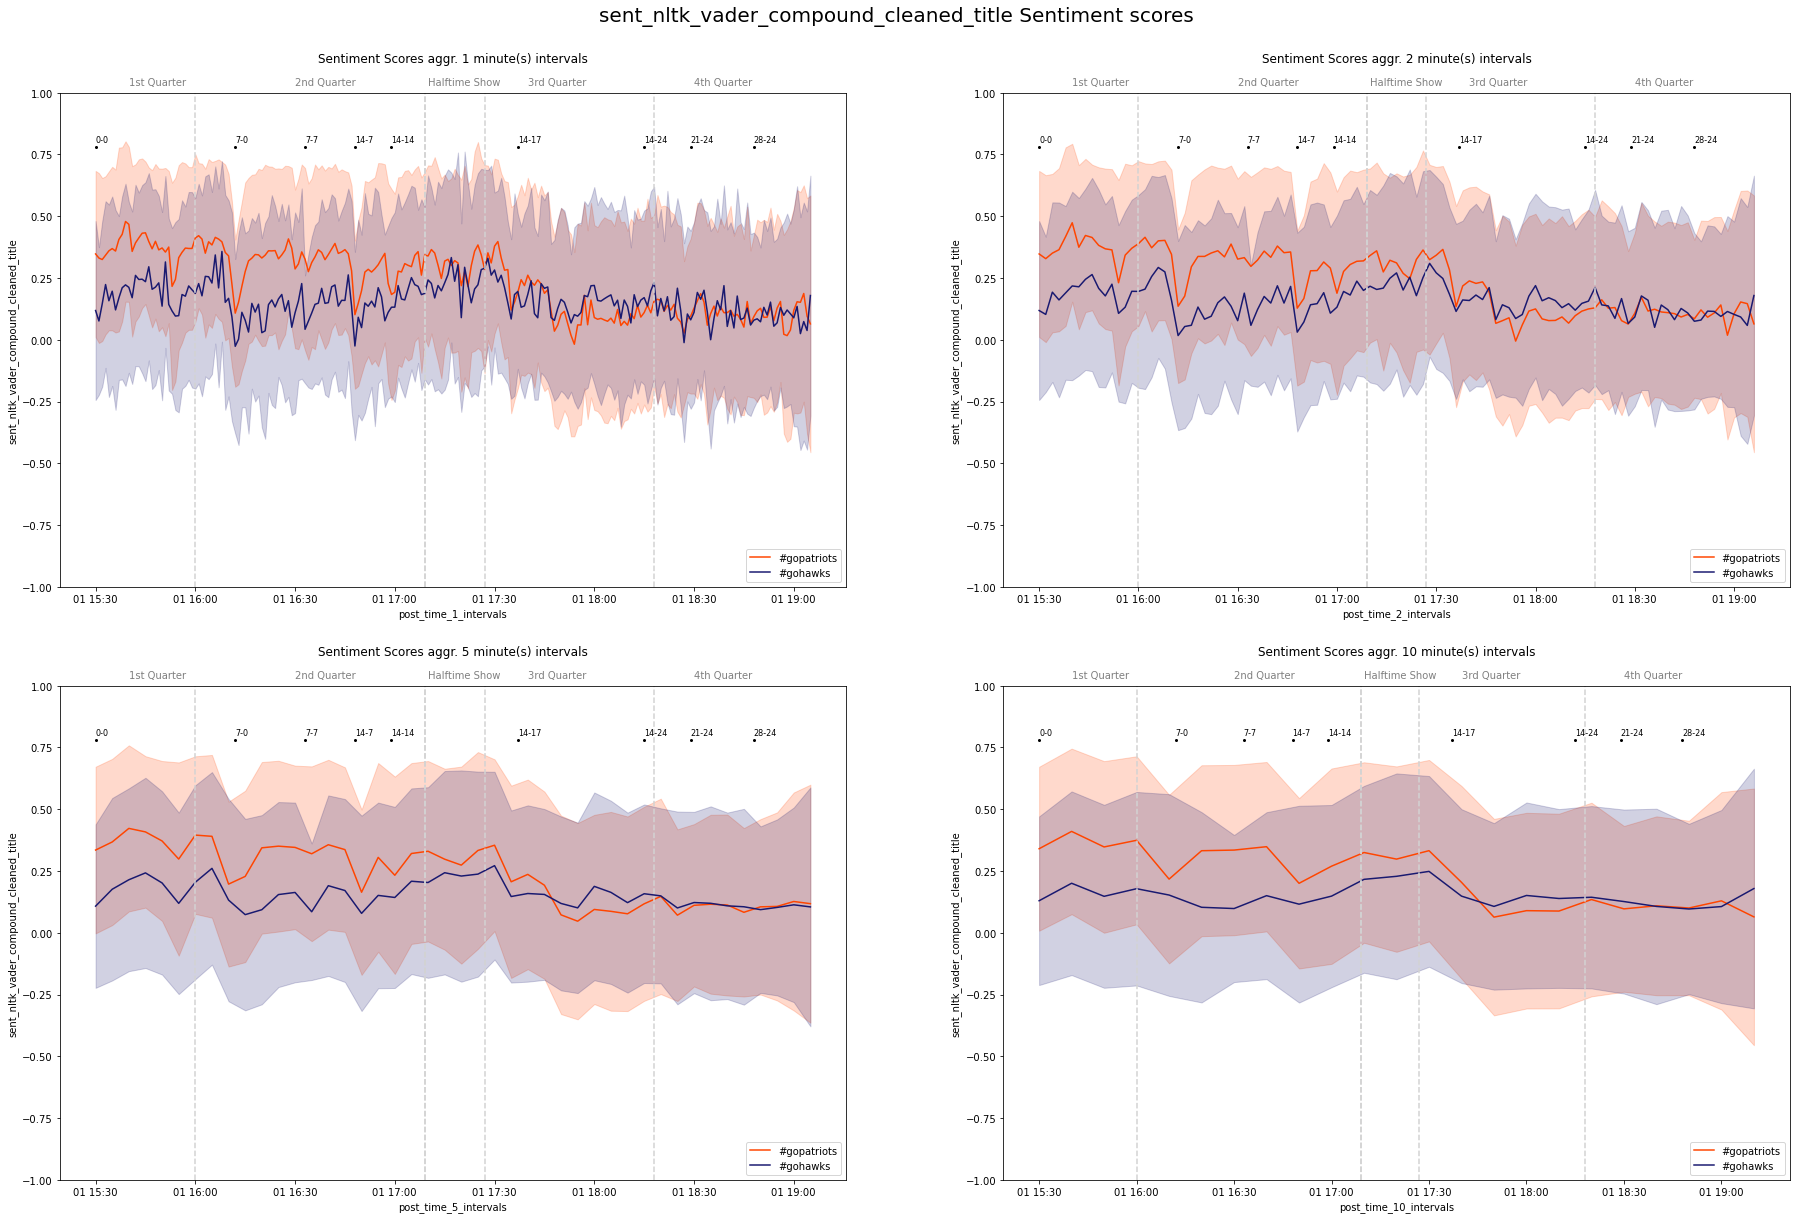

In [75]:
# Draw Fans emotion overtime aggregated on different time intervals:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(31,20))
plt.suptitle(f'{sentiment_feature} Sentiment scores', y=0.94, fontsize=20)
for interval, ax_ind in zip([1,2,5,10], ax.ravel()):
    title = f'Sentiment Scores aggr. {interval} minute(s) intervals'
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=interval, sentiment_feat=sentiment_feature, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=title, ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=ax_ind)
    #ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
plt.show()

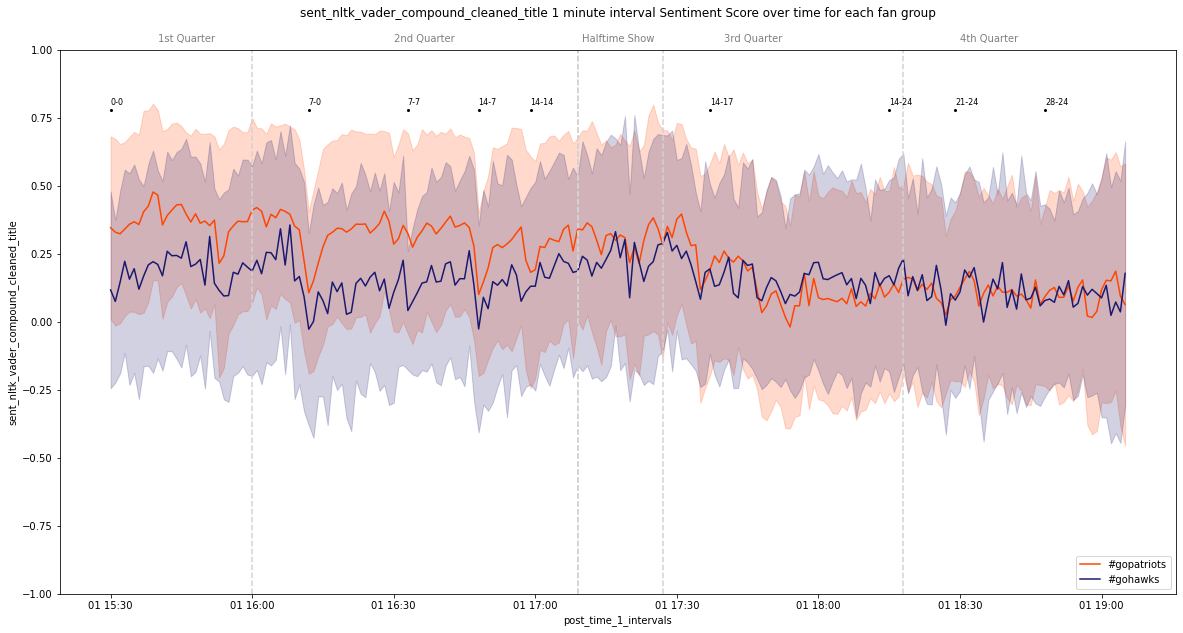

In [76]:
plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=1, sentiment_feat=sentiment_feature, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=f'{sentiment_feature} 1 minute interval Sentiment Score over time for each fan group', 
                             ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=None) # ci=None

###### __Draw Fans emotion for different sentiment feature types__

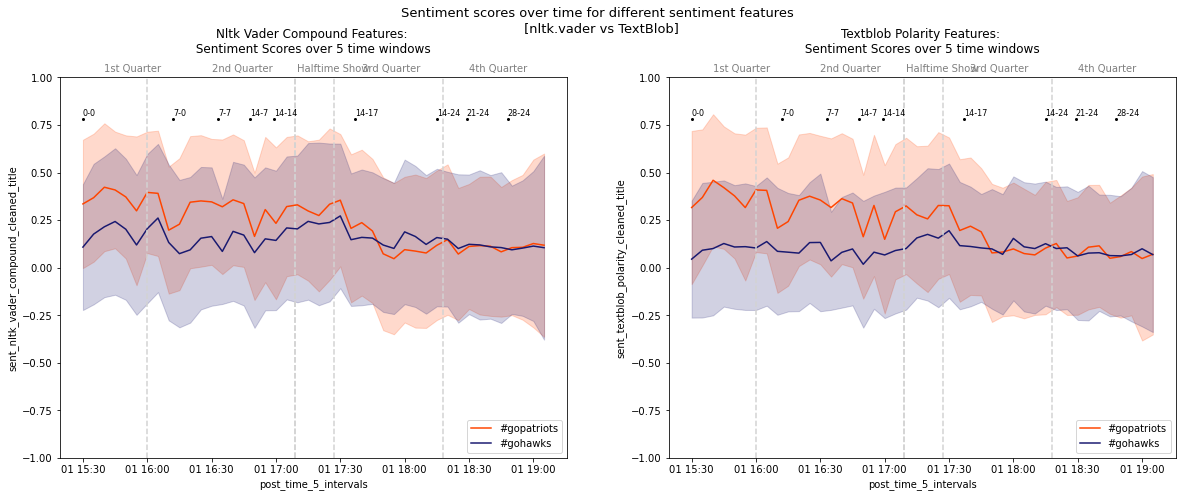

In [77]:
# Draw Fans emotion for different sentiment feature types
sentiment_feature = 'sent_nltk_vader_compound'+'_'+twt_feature_name   #sent_nltk_vader_compound, 'sent_textblob_polarity'
time_window = 5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
plt.suptitle(f'Sentiment scores over time for different sentiment features \n [nltk.vader vs TextBlob]', y=1.02, fontsize=13)
for snt, ax_ind in zip(['sent_nltk_vader_compound','sent_textblob_polarity' ], ax.ravel()):
    sentiment_feat = snt+'_'+twt_feature_name 
    title = f'{" ".join(sentiment_feat.split("_")[1:-2]).title()} Features: \n Sentiment Scores over {time_window} time windows '
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df, time_int=time_window, sentiment_feat=sentiment_feat, 
                             groupby_list=['hashtag'], is_during_game=True,
                             title=title, ylab='', xlab='', hue='hashtag', ci='sd', figsize=(20,10), ax_ind=ax_ind)
    #ax_ind.set_title(f'{ft}{twt_feature_name} \nSentiment {s} Distribution')
plt.show()

###### __Draw Fans emotion for different players__

Who are the most tweeted players?

In [78]:
twt_counts_per_player = pd.concat([pd.DataFrame(tweet_emt_df.player2.value_counts()),pd.DataFrame( tweet_emt_df.player2.value_counts(normalize=True))], axis=1)
twt_counts_per_player.columns = ['tweet_counts', 'tweet_percentage']
display(twt_counts_per_player.T)

,#gopatriots,#gohawks,Tom Brady,Russell Wilson,Rob Gronkowski,Marshawn Lynch,Richard Sherman,Chris Matthews,Julian Edelman,Earl Thomas,...,Patrick Chung,K.J. Wright,Dont'a Hightower,Ricardo Lockette,Michael Bennett,Byron Maxwell,Rob Ninkovich,DeShawn Shead,Sealver Siliga,Robert Turbin
tweet_counts,357785.000000,115377.000000,32383.000000,8710.00000,5395.000000,4845.000000,4314.00000,2753.000000,2439.000000,2130.000000,...,163.000000,141.000000,132.00000,122.000000,118.000000,88.00000,71.000000,57.000000,45.000000,11.00000
tweet_percentage,0.649418,0.209421,0.058779,0.01581,0.009792,0.008794,0.00783,0.004997,0.004427,0.003866,...,0.000296,0.000256,0.00024,0.000221,0.000214,0.00016,0.000129,0.000103,0.000082,0.00002


What are the top players for each hashtag? Are the players play in defense or offense? Are the 10 players of each hashtag is for that team or the rival team?

Below table shows top 10 players for each hashtag:

In [79]:
sub_players_df = players_df[['Player', 'Pos', 'Team', 'Position','Category']]
tweet_emt_df = tweet_emt_df.merge(sub_players_df, how='left', left_on='player2', right_on='Player')

In [80]:
bys = ['hashtag', 'player2', 'Team', 'Category' ]
twt_counts_per_player_hsh = pd.DataFrame(tweet_emt_df.groupby(bys).title.count())
twt_counts_per_player_hsh.columns = ['tweeet_count']
twt_counts_per_player_hsh.sort_values(by=['hashtag','tweeet_count'], ascending=False, inplace=True)
twt_counts_per_player_hsh.reset_index(inplace=True)
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gopatriots'].head(10).T)
display(twt_counts_per_player_hsh[twt_counts_per_player_hsh.hashtag=='#gohawks'].head(10).T)

,0,1,2,3,4,5,6,7,8,9
hashtag,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots,#gopatriots
player2,Tom Brady,Rob Gronkowski,Julian Edelman,LeGarrette Blount,Richard Sherman,Marshawn Lynch,Russell Wilson,Darrelle Revis,Chris Matthews,Earl Thomas
Team,Patriots,Patriots,Patriots,Patriots,Seahawks,Seahawks,Seahawks,Patriots,Seahawks,Seahawks
Category,Offense,Offense,Offense,Offense,Defense,Offense,Offense,Defense,Offense,Defense
tweeet_count,28360,4327,2401,1907,1457,1306,1246,1245,1156,1037


,39,40,41,42,43,44,45,46,47,48
hashtag,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks
player2,Russell Wilson,Tom Brady,Marshawn Lynch,Richard Sherman,Chris Matthews,Doug Baldwin,Earl Thomas,Rob Gronkowski,Kam Chancellor,Jermaine Kearse
Team,Seahawks,Patriots,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Patriots,Seahawks,Seahawks
Category,Offense,Offense,Offense,Defense,Offense,Offense,Defense,Offense,Defense,Offense
tweeet_count,7464,4023,3539,2857,1597,1307,1093,1068,843,518


We can see that the most of the tweets about players belong to #gohawks hashtag, it makes sense since the number of tweets belong to each hashtag is highly unbalanced. We can see that hawks supporters tends to talk more about Seahawks players whilst patriots fan talks for players of both teams 5/10 top players mentioned in #gopatriots hashtags are SeaHawks players (though the count of these tweets are very small.).  In both of the hashtags majority of the comments are for offense players than defense players. #gopatriots mainly talks about opposite team's defense players when the player's category is defense. This potentially means that even talking about defense players, patriots fan are more focusing on the offense moments of their team.
We may conclude that fans are more interested talking about attack moments of their team (deffense of opposing team). 

Choose top 8 tweeted players in the plot:

['Tom Brady', 'Russell Wilson', 'Rob Gronkowski', 'Marshawn Lynch', 'Richard Sherman', 'Chris Matthews', 'Julian Edelman', 'Earl Thomas']


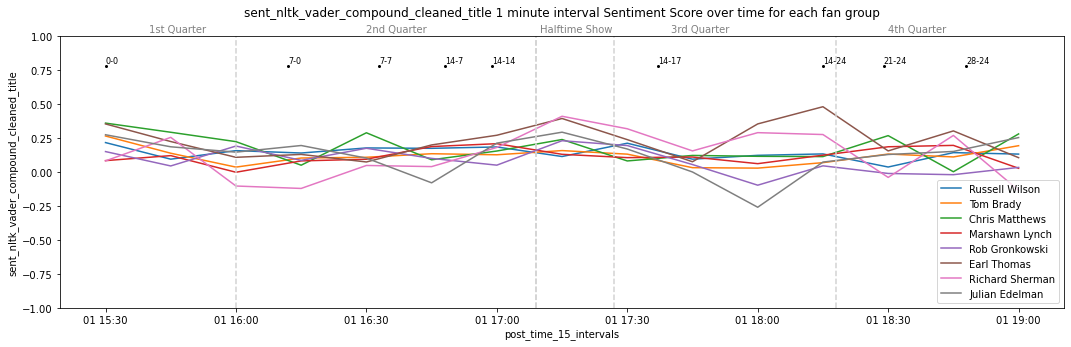

In [83]:
selected_pls = list(twt_counts_per_player.index)[2:10]
print(selected_pls)
sb_df = tweet_emt_df[tweet_emt_df.player2.isin(selected_pls)]
plot_emotion_by_interval(tweet_emt_df=sb_df, time_int=15, sentiment_feat=sentiment_feature, 
                             groupby_list=['player2'], is_during_game=True,
                             title=f'{sentiment_feature} 1 minute interval Sentiment Score over time for each fan group', 
                             ylab='', xlab='', hue='player2', ci=None, figsize=(18,5), ax_ind=None)

#marker='o', markersize=5

Notice that 6 of the 8 top tweeted players are from Seahawks. TODO comment

###### __Draw Fans emotion for individual players__

In [ ]:
#todo

['#gopatriots', '#gohawks', 'Tom Brady', 'Russell Wilson', 'Rob Gronkowski', 'Marshawn Lynch', 'Richard Sherman', 'Chris Matthews', 'Julian Edelman', 'Earl Thomas']


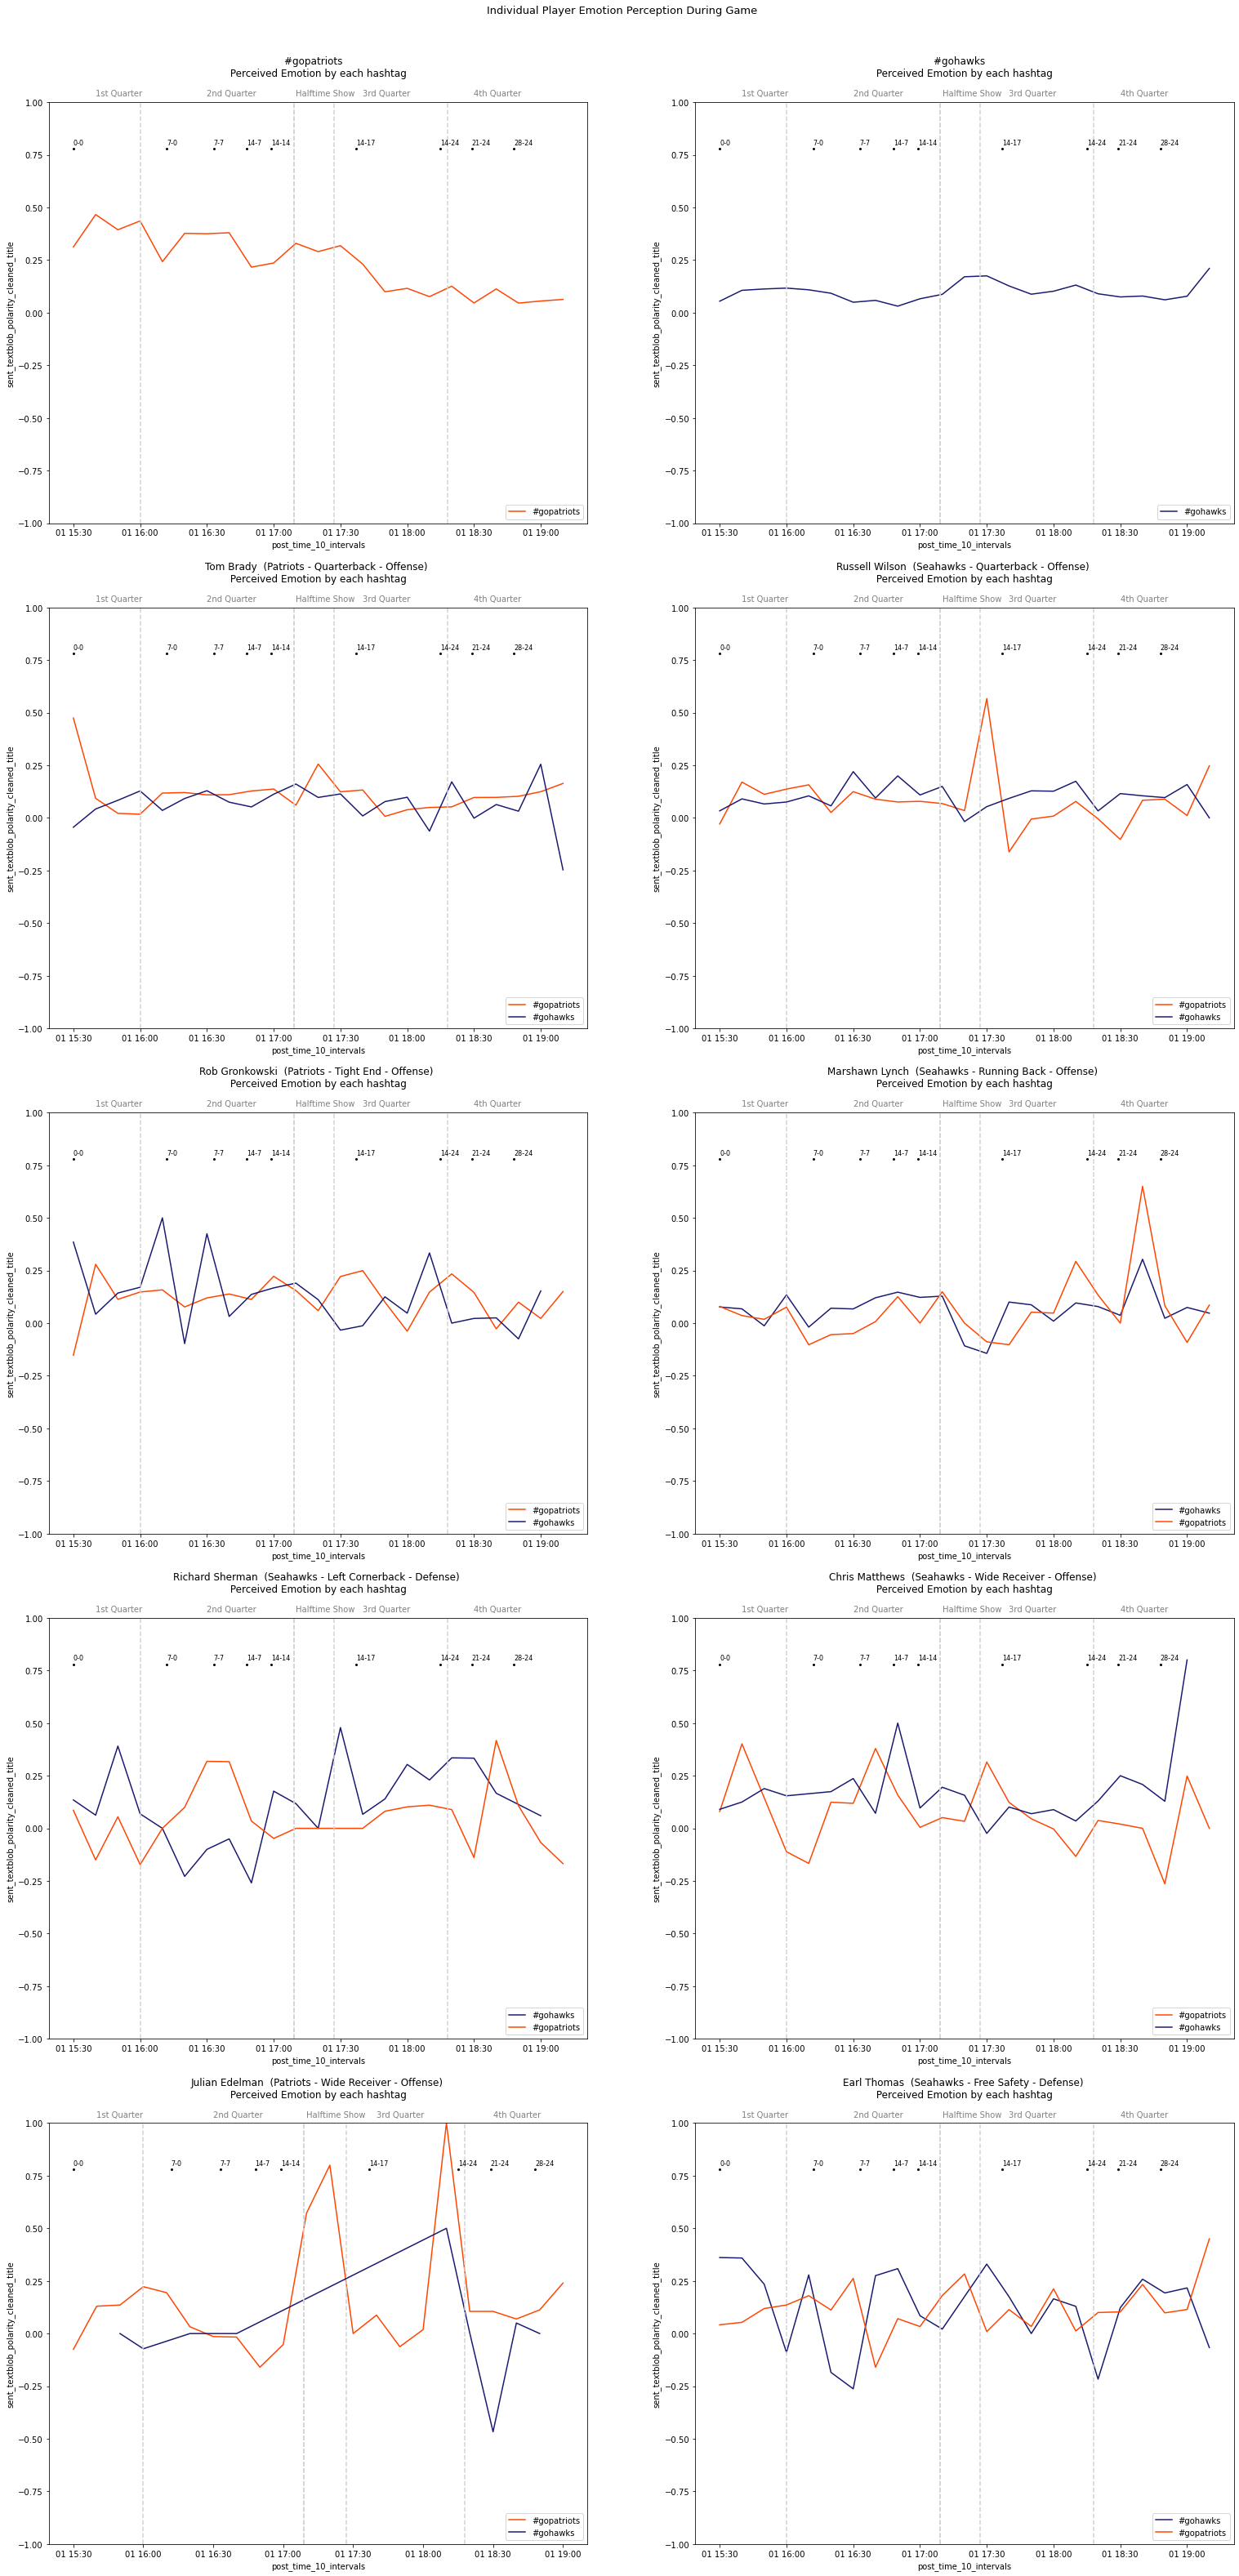

In [84]:
# Draw Fans emotion for each player separately 
time_window = 10
selected_pls = list(twt_counts_per_player.index)[:10]
print(selected_pls)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(26,55))
plt.suptitle(f'Individual Player Emotion Perception During Game', y=0.91, fontsize=13)
for ply, ax_ind in zip(selected_pls, ax.ravel()):
    ply_df = players_df[players_df.Player==ply]
    team = ply_df.Team.values[0] if not ply_df.empty else ''
    pos = ply_df.Position.values[0] if not ply_df.empty else ''
    cat = ply_df.Category.values[0] if not ply_df.empty else ''
    infix = f'({team} - {pos} - {cat})' if pos else ''
    title = f'{ply}  {infix} \n Perceived Emotion by each hashtag '
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df[tweet_emt_df.player2==ply], 
                                        time_int=time_window, sentiment_feat=sentiment_feat, 
                                         groupby_list=['hashtag'], is_during_game=True,
                                         title=title, ylab='', xlab='', hue='hashtag', ci=None, figsize=(20,6), ax_ind=ax_ind)
plt.show()

In [ ]:
# todo comment

###### __Draw Fans emotion on pairwise players__

In [85]:
bys = ['Team', 'player2', 'Category' ]
twt_counts_per_player_hsh2 = pd.DataFrame(tweet_emt_df.groupby(bys).title.count())
twt_counts_per_player_hsh2.columns = ['tweeet_count']
twt_counts_per_player_hsh2.sort_values(by=['Team','tweeet_count'], ascending=False, inplace=True)
twt_counts_per_player_hsh2.reset_index(inplace=True)

display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Patriots'].head(10).T)
display(twt_counts_per_player_hsh2[twt_counts_per_player_hsh2.Team=='Seahawks'].head(10).T)

,20,21,22,23,24,25,26,27,28,29
Team,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots
player2,Tom Brady,Rob Gronkowski,Julian Edelman,LeGarrette Blount,Darrelle Revis,Vince Wilfork,Brandon LaFell,Michael Hoomanawanui,Chandler Jones,Danny Amendola
Category,Offense,Offense,Offense,Offense,Defense,Defense,Offense,Offense,Defense,Offense
tweeet_count,32383,5395,2439,1948,1342,949,868,737,507,491


,0,1,2,3,4,5,6,7,8,9
Team,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks,Seahawks
player2,Russell Wilson,Marshawn Lynch,Richard Sherman,Chris Matthews,Earl Thomas,Doug Baldwin,Kam Chancellor,Jermaine Kearse,Bryan Walters,Tony McDaniel
Category,Offense,Offense,Defense,Offense,Defense,Offense,Defense,Offense,Offense,Defense
tweeet_count,8710,4845,4314,2753,2130,1541,1010,646,585,430


For offense and defense use players other than Tom Brady and Russell Wilson since we already compared them in Passing Leaders.

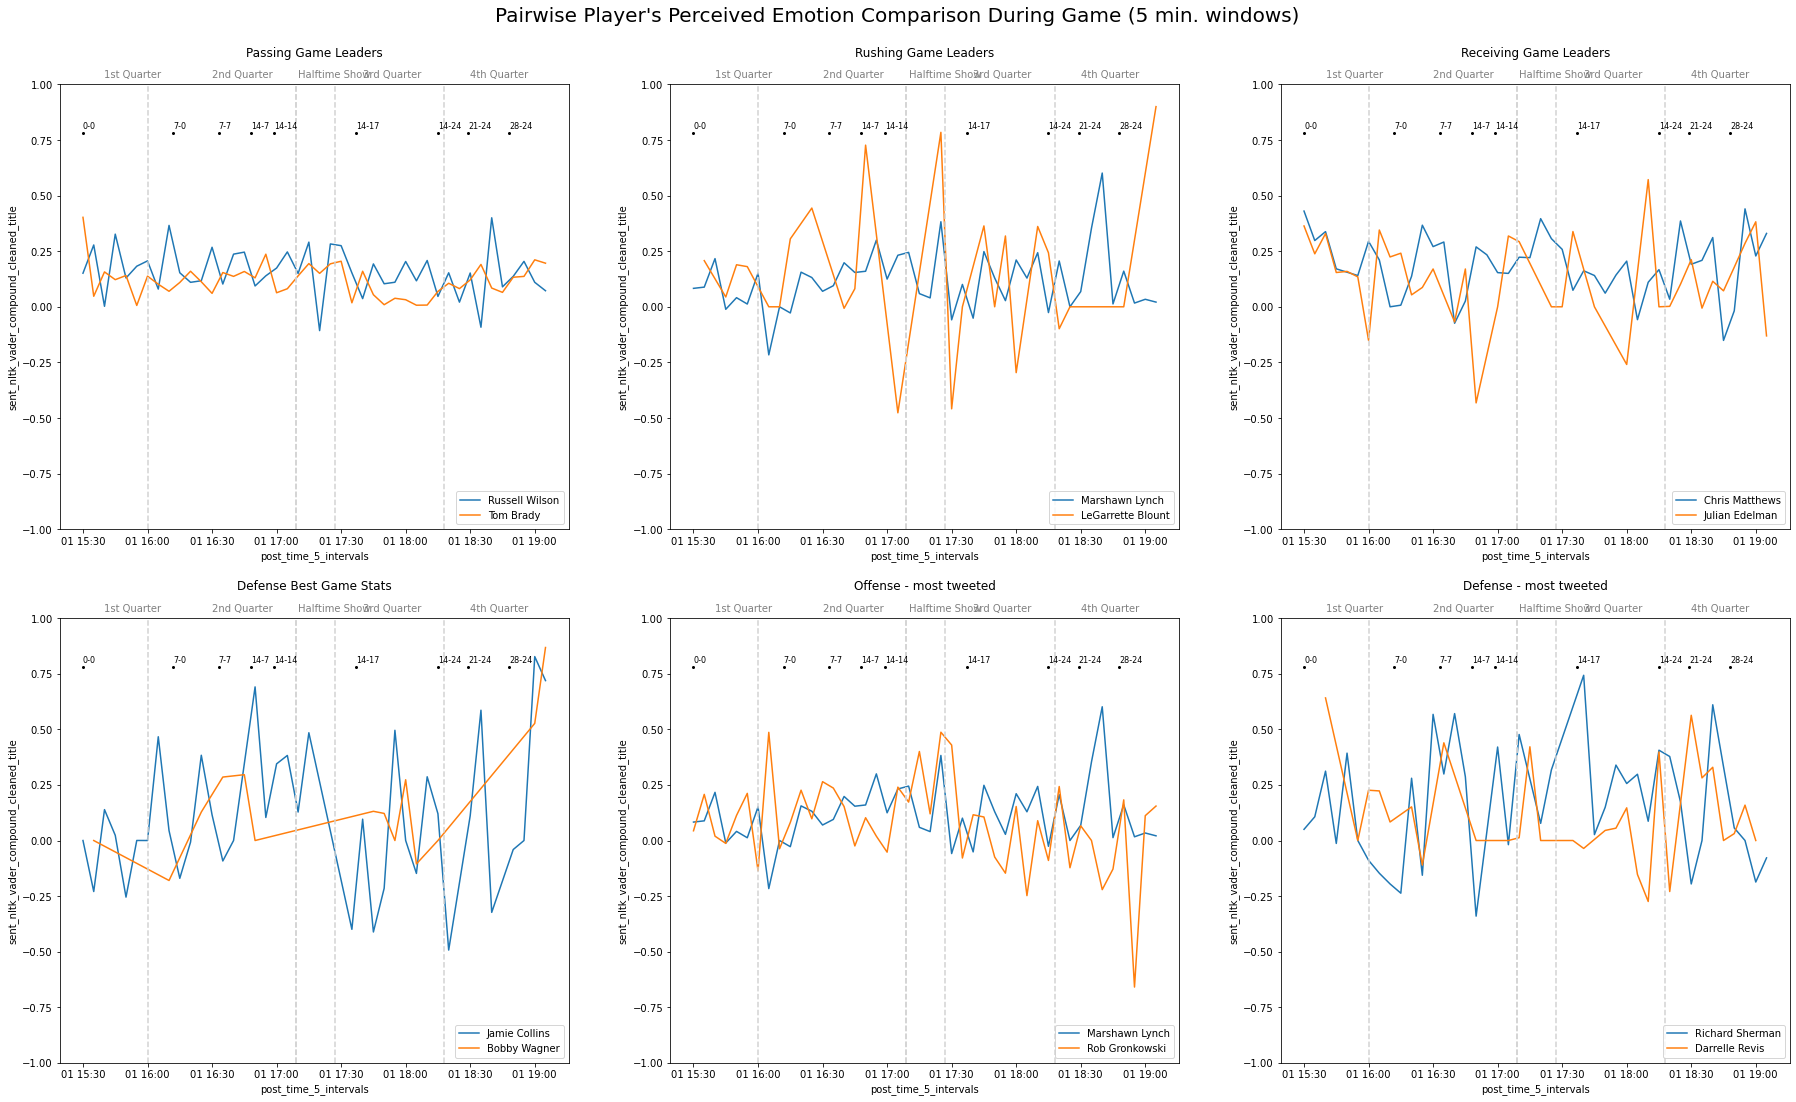

In [87]:
pairs = [('Passing Game Leaders',['Tom Brady','Russell Wilson']),
         ('Rushing Game Leaders',['LeGarrette Blount','Marshawn Lynch']),
         ('Receiving Game Leaders',['Julian Edelman','Chris Matthews']),
         ('Defense Best Game Stats',['Jamie Collins','Bobby Wagner']),
         ('Offense - most tweeted',['Rob Gronkowski','Marshawn Lynch']),
         ('Defense - most tweeted',['Darrelle Revis','Richard Sherman']),      
]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(31,18))
tm_int = 5
plt.suptitle(f"Pairwise Player's Perceived Emotion Comparison During Game ({tm_int} min. windows)", y=0.94, fontsize=20)
for (name, plys), ax_ind in zip(pairs, ax.ravel()):
    title = f'{name}'
    plot_emotion_by_interval(tweet_emt_df=tweet_emt_df[tweet_emt_df.player2.isin(plys)], 
                                        time_int=tm_int, sentiment_feat=sentiment_feature, 
                                         groupby_list=['player2'], is_during_game=True, 
                                         title=title, ylab='', xlab='', hue='player2', ci=None, figsize=(20,6), ax_ind=ax_ind)
plt.show()

In [ ]:
# todo comment

#### plots

In [ ]:
df['Max'] = df[['Communications','Business']].idxmax(axis=1)

In [88]:
tweet_emt_df.columns

Index(['index', 'hashtag', 'title', 'tweet.text', 'citation_date',
       'tweet.lang', 'tweet.user.name', 'original_author.name',
       'tweet.retweet_count', 'tweet.favorite_count',
       'metrics.citations.total', 'metrics.impressions',
       'tweet.user.followers_count', 'tweet.user.friends_count',
       'tweet.user.favourites_count', 'citation_date_fixed',
       'citation_date_year', 'citation_date_month', 'citation_date_day',
       'citation_date_hour', 'citation_date_rounded_hour', 'player',
       'player_count', 'players_str', 'player2', 'game_status',
       'sent_nltk_vader_neg_title', 'sent_nltk_vader_neu_title',
       'sent_nltk_vader_pos_title', 'sent_nltk_vader_compound_title',
       'sent_nltk_vader_label_title', 'sent_textblob_polarity_title',
       'sent_textblob_subjectivity_title', 'sent_textblob_label_title',
       'cleaned_title', 'mention_count', 'hashtag_count',
       'cleaned_hashtag_title', 'sent_nltk_vader_neg_cleaned_title',
       'sent_nltk_vade

## Prediction Task

#### 1.2. Time series: From tweet emotions expressed to players in time windows can we predict who is winning?

- based on emotions for players (or fans) which team is winnnig the game timeseries prediction.

Next step is then assigning labels for each tweet: two columns created for each tweet 1- game score relative to when the tweet is posted and 2- who is leading the game (tie, seahawks, patriots) in the relative time of tweet posted. 


### prepare data for ML modelling

In [ ]:
pls = list(players_df.Player) 
player_feature = 'player2'
sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') 
                      # & (tweet_emt_df.player_count==1) 
                      #& (tweet_emt_df.players_str.isin(pls))
                     ]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature, player_feature ])[sentiment_feature].sum())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

In [ ]:
tweet_emt_df.player2.value_counts()

In [ ]:
def get_label(post_date):
    df = score_time_df[score_time_df[time_interval_feature] <= post_date]
    scr =  '' if df.empty else df.score.values[-1]
    lbl =  '' if df.empty else df.leading.values[-1]
    return [scr, lbl]


model_data = fan_sentiments_df.pivot_table(columns =[player_feature, ], index=[time_interval_feature], values=[sentiment_feature])
model_data.reset_index(inplace=True)
model_data = model_data.sort_values(by=[time_interval_feature])
model_data = model_data.set_index([time_interval_feature])
model_data.columns = model_data.columns.droplevel(0)
model_data = model_data.reset_index()
model_data.rename(columns={'':time_interval_feature}, inplace=True)
model_data[['score','leading']] = model_data.apply(lambda x: get_label(x[time_interval_feature]), axis=1, result_type='expand')
model_data

In [ ]:
# todo check which players appears how many of the time frames/ intervals?

In [ ]:
model_data.describe()

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        return_train_score=True,
        return_estimator=True
        #scoring=["accuracy", "f1"],
    )
    #avg_acc = cv_results["test_mean_accuracy"]
    #avg_f1 = cv_results["test_mean_f1"]
    #print(avg_acc, avg_f1)
    #print(
    #    f"Mean Absolute Error:     {avg_acc:.3f} +/- {mae.std():.3f}\n"
    #    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    #)
    return cv_results

In [ ]:
#most_tweeted_pls = list(tweet_emt_df['player2'].value_counts().index)

In [ ]:
pls = list(tweet_emt_df.player2)
pls = ['#gohawks', '#gopatriots', 'Bobby Wagner',
       'Brandon Browner', 'Brandon LaFell', 'Bruce Irvin', 'Bryan Walters',
       'Byron Maxwell', 'Chandler Jones', 'Chris Matthews', 'Cliff Avril', #'Dan Connolly',
       'Danny Amendola', 'Darrelle Revis', 'Devin McCourty',
       'Doug Baldwin', 'Earl Thomas', 'J.R. Sweezy', 'James Carpenter',
       'Jamie Collins', 'Jermaine Kearse', 'Julian Edelman', 'Justin Britt',
       'K.J. Wright', 'Kam Chancellor', 'Kevin Williams', 'Kyle Arrington',
       'LeGarrette Blount', 'Luke Willson', 'Marshawn Lynch', 'Max Unger',
       'Michael Bennett', 'Michael Hoomanawanui', 'Patrick Chung',
       'Ricardo Lockette', 'Richard Sherman', 'Rob Gronkowski',
       'Rob Ninkovich', 'Robert Turbin', 'Russell Wilson', 'Ryan Wendell',
       'Sebastian Vollmer', 'Shane Vereen', 'Tom Brady', 'Tony McDaniel',
       'Vince Wilfork']
X =  model_data[pls]
y = model_data['leading']

print(len(y))
display(y.value_counts(normalize=True))

drop_cols = True #True
print(X.shape)
int_NA = int(0.6*X.shape[0])
print(int_NA)
if drop_cols:
    X = X.dropna(thresh=int_NA, axis=1)

X = X.fillna(0)
X.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)
#clf = LogisticRegression(random_state=0, penalty='l2', solver='saga', class_weight='balanced')
clf = RandomForestClassifier(n_estimators=40, max_depth=4, random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=500)

cv_results = evaluate(clf, X_train, y_train, cv=10)
#print(cv_results)
print(cv_results['test_score'].mean())
print(cv_results['test_score'])

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds)
print(Counter(preds))
print(clf.score(X_test, y_test))
print(X.columns)

In [ ]:
importances = clf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar(figsize=(9,5))
#title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
plt.show()
print(forest_importances)

In [ ]:
coeffs = pd.DataFrame(clf.coef_.T, columns=clf.classes_)
coeffs['features'] = X.columns
coeffs = coeffs.set_index('features')
#coeffs
for lbl in ['Patriots', 'Seahawks', 'Tie']:
    coeffs[coeffs[lbl]!=0][lbl].plot(kind="bar", figsize=(20, 5))
    plt.title(lbl)
    plt.show()

In [ ]:
# vader 109, 12 -- title, 0.2 drop
clf = RandomForestClassifier(n_estimators=40, max_depth=3, random_state=0, class_weight='balanced')

# old

In [ ]:
pls = list(players_df.Player) 
player_feature = 'player2'
sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') 
                      # & (tweet_emt_df.player_count==1) 
                      #& (tweet_emt_df.players_str.isin(pls))
                     ]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag',player_feature ])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

In [ ]:
def get_label(post_date):
    df = score_time_df[score_time_df[time_interval_feature] <= post_date]
    scr =  '' if df.empty else df.score.values[-1]
    lbl =  '' if df.empty else df.leading.values[-1]
    return [scr, lbl]


model_data = fan_sentiments_df.pivot_table(columns =[player_feature, ], index=[time_interval_feature], values=[sentiment_feature])
model_data.reset_index(inplace=True)
model_data = model_data.sort_values(by=[time_interval_feature])
model_data.columns = model_data.columns.droplevel(0)
model_data.rename(columns={'':time_interval_feature}, inplace=True)
model_data[['score','leading']] = model_data.apply(lambda x: get_label(x[time_interval_feature]), axis=1, result_type='expand')
model_data

#### task 1 modelling

In [ ]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        return_train_score=True,
        return_estimator=True
        #scoring=["accuracy", "f1"],
    )
    #avg_acc = cv_results["test_mean_accuracy"]
    #avg_f1 = cv_results["test_mean_f1"]
    #print(avg_acc, avg_f1)
    #print(
    #    f"Mean Absolute Error:     {avg_acc:.3f} +/- {mae.std():.3f}\n"
    #    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    #)
    return cv_results

In [ ]:
#most_tweeted_pls = list(tweet_emt_df['player2'].value_counts().index)

In [ ]:
pls = list(tweet_emt_df.player2)
pls = ['#gohawks', '#gopatriots', 'Bobby Wagner',
       'Brandon Browner', 'Brandon LaFell', 'Bruce Irvin', 'Bryan Walters',
       'Byron Maxwell', 'Chandler Jones', 'Chris Matthews', 'Cliff Avril', #'Dan Connolly',
       'Danny Amendola', 'Darrelle Revis', 'Devin McCourty',
       'Doug Baldwin', 'Earl Thomas', 'J.R. Sweezy', 'James Carpenter',
       'Jamie Collins', 'Jermaine Kearse', 'Julian Edelman', 'Justin Britt',
       'K.J. Wright', 'Kam Chancellor', 'Kevin Williams', 'Kyle Arrington',
       'LeGarrette Blount', 'Luke Willson', 'Marshawn Lynch', 'Max Unger',
       'Michael Bennett', 'Michael Hoomanawanui', 'Patrick Chung',
       'Ricardo Lockette', 'Richard Sherman', 'Rob Gronkowski',
       'Rob Ninkovich', 'Robert Turbin', 'Russell Wilson', 'Ryan Wendell',
       'Sebastian Vollmer', 'Shane Vereen', 'Tom Brady', 'Tony McDaniel',
       'Vince Wilfork']
X =  model_data[pls]
y = model_data['leading']

print(len(y))
display(y.value_counts(normalize=True))

drop_cols = False #True
print(X.shape)
int_NA = int(0.4*X.shape[0])
print(int_NA)
if drop_cols:
    X = X.dropna(thresh=int_NA, axis=1)

X = X.fillna(0)
X.shape

In [ ]:
#clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', class_weight='balanced')
#clf = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=200, learning_rate_init=0.6)

cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
print(cv_results['test_score'].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds)
print(Counter(preds))
print(clf.score(X_test, y_test))
print(X.columns)
#print(clf.coef_) #.feature_importances_)
#print(cv_results['estimator'][0].coef_) #.feature_importances_)

#print(clf.feature_importances_) #.feature_importances_)
#print(cv_results['estimator'][0].feature_importances_) #.feature_importances_)

In [ ]:
coeffs = pd.DataFrame(clf.coef_.T, columns=clf.classes_)
coeffs['features'] = X.columns
coeffs = coeffs.set_index('features')

coeffs

In [ ]:
coeffs.plot(kind="barh", figsize=(5, 20))
plt.show()

In [ ]:
forest_importances

In [ ]:
importances = cv_results['estimator'][0].feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [ ]:
# vader 109, 12 -- title, 0.2 drop
clf = RandomForestClassifier(n_estimators=40, max_depth=3, random_state=0, class_weight='balanced')

##### timeseries 

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=105,
    gap=0,
    max_train_size=3,
    test_size=1,
)

#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [ ]:
pd.DataFrame(y).T

In [ ]:
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#clf = LogisticRegression(random_state=0)
clf = RandomForestClassifier(n_estimators=400, max_depth=1,random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=500)
cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
cv_results['test_score'].mean()

In [ ]:
y.value_counts(normalize=True)

In [ ]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
all_splits

# delete splits where train same

In [ ]:
# X.iloc[train_0]
# X.iloc[test_0]

In [ ]:
y

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=4.0, max_depth=1, random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
cv_results['test_score'].mean()

In [ ]:
cv_results['estimator'][0].feature_impo

In [ ]:
clf = LogisticRegression(random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][0].coef_)

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][10].feature_importances_)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=300,  learning_rate_init=10.1,)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
#print(cv_results['estimator'][10].feature_importances_)